# Lab One
### Visualization and Data Preprocessing of LendingClub Loan Data
#### Ricco Ferraro, David Grijalva, Nicole Norelli, & Mingyang Nick Yu


## Business Understanding
We selected data from LendingClub, a peer-to-peer lending company where individuals can apply for loans and investors can elect to commit money. The dataset we downloaded was from Kaggle. It contains 2,925,493 records and 141 attributes collected between 2007 and 2020 and was available to the public through LendingClub. The original purpose of the data collected was for LendingClub to accept or reject a loan application as well as assign the loan a grade and interest rate. This is a valuable dataset because each entry has extensive information about the borrower, loan terms, and loan outcome.

The two outcomes we chose to predict are loan outcome and loan grade. Loan outcome is a useful variable to predict, as it allows investors to make better, more informed decisions when deciding to fund a loan. The ability to predict if a particular loan will be fully paid or charged off (deemed un-collectible) allows investors to optimize their investments. There is value in making this prediction prospectively before a lender grants a loan or alternately midway through the life of an existing loan. We have two loan outcome attributes: the original attribute with eight categories and a feature we created that simplifies it down to two categories. Either way, this prediction is a classification problem and we plan to use the precision of each group as an evaluation metric. A high precision for the good loan group would allow LendingClub to continue offering loans to this group of people and to collect interest from good loans. A high precision for the bad loan group can help LendingClub detect potential bad loans prior to issuance and save money from potential bad loans. We can use 10-fold cross validation on our sample as a model selection tool to choose the winning model that produces the highest reliable precision across both groups.

Our second outcome was loan grade. This grade is assigned to the loan by LendingClub. The factors that determine the grade are not disclosed to the public, but the grade determines the interest rate assigned to a particular loan. The ability to predict grade could be useful to both competitors and loan applicants. Competitors could be interested in the strategy LendingClub uses to grade loans, and loan applicants could be interested in determining the optimal way to improve their own loan grade and therefore obtain a lower interest rate. Again, this is a classification problem, and we plan to use precision as an evaluation matric. A good prediction precision evenly distributed across groups A to G would indicate a good performance for our model in correctly predicting loan grade with given borrower information. We can also utilize 10-fold cross validation on our sample as a model selection tool to choose the winning model that produces high precision evenly across loan grade groups.

_https://www.lendingclub.com_

_https://www.kaggle.com/ethon0426/lending-club-20072020q1_

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import pickle
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import re
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from IPython.core.display import display, HTML
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.decomposition import PCA as sk_PCA
from scipy.spatial import distance
from scipy.cluster import hierarchy

# Notebook options
pd.options.display.max_rows = 99999
pd.options.display.max_columns = 99999
#pd.options.display.float_format = '{:20,.3f}'.format

In [2]:
%time data = pd.read_pickle("loan_100k_sample.pkl")

CPU times: user 144 ms, sys: 103 ms, total: 247 ms
Wall time: 246 ms


#### Subset of the full data set
Because our dataset was so large, we decided to take a random subset of 100,000 records beginning in January 2015. We believed more recent data would be more representative of current financial conditions for our model. The longest loans available from LendingClub are 60 months, so choosing a cut-off of more than five years in the past should allow for  records from a variety of points within the two loan terms (ranging from just issued to paid off).

## Data Quality
### Missing Data

In [3]:
# Identify attributes missing over 15% of values
columns_missing_rate = 100*(data.isnull().sum(axis = 0) / len(data))
columns_missing_rate = pd.DataFrame(columns_missing_rate)
columns_missing_rate = columns_missing_rate.reset_index()
columns_missing_rate.columns = ['name','rate']
print("     Initial Missing Data Inspection with all Attributes In     \n")
print('{:45s} {:4s}%'.format("Variable Name:","Missing Percentage"))
print("________________________________________________________________")
for index, row in columns_missing_rate.iterrows():
    if row['rate'] > 0:
        print(' {:45s} {:4s}%'.format(row['name'],str(np.round(row['rate'],4))))

     Initial Missing Data Inspection with all Attributes In     

Variable Name:                                Missing Percentage%
________________________________________________________________
 emp_title                                     9.557%
 emp_length                                    7.468%
 title                                         0.967%
 dti                                           0.113%
 inq_last_6mths                                0.001%
 mths_since_last_delinq                        52.227%
 mths_since_last_record                        85.29%
 revol_util                                    0.08%
 last_pymnt_d                                  0.203%
 next_pymnt_d                                  56.961%
 last_credit_pull_d                            0.001%
 mths_since_last_major_derog                   74.639%
 annual_inc_joint                              91.643%
 dti_joint                                     91.643%
 verification_status_joint                 

__The following code chunk is the process of dropping attributes (see Deletion below)__

In [4]:
columns_to_delete = []
for index, row in columns_missing_rate.iterrows():
    if row['rate'] >= 15:
        columns_to_delete.append(row['name'])
columns_to_delete.sort()
# Keep sec_app_fico variables for later use
columns_to_delete.remove('sec_app_fico_range_low')
columns_to_delete.remove('sec_app_fico_range_high')
data.drop(columns_to_delete,axis=1,inplace=True)
group_agreed_deletation = ['id','sub_grade','initial_list_status','last_credit_pull_d',
                           'mths_since_recent_inq','num_accts_ever_120_pd',
                          'num_bc_sats','num_bc_tl','num_op_rev_tl','num_rev_accts',
                          'num_rev_tl_bal_gt_0','num_sats','num_tl_120dpd_2m',
                          'num_tl_30dpd','num_tl_op_past_12m','total_pymnt',
                          'total_pymnt_inv','url','zip_code','emp_title']
data.drop(group_agreed_deletation,axis=1,inplace=True)
nick_suggested_deletation = ['avg_cur_bal','bc_open_to_buy','collection_recovery_fee',
                             'funded_amnt','funded_amnt_inv','installment','num_actv_bc_tl',
                            'out_prncp_inv','percent_bc_gt_75','policy_code','pub_rec',
                             'tot_hi_cred_lim','total_acc','total_il_high_credit_limit',
                            'total_rec_int','total_rev_hi_lim','pymnt_plan','title']
data.drop(nick_suggested_deletation,axis=1,inplace=True)

__The following code chunk is the process of imputation (see Imputation below)__

In [5]:
# Imputation
# Write code chunk fixing emp_length NA to less than one year
def emp_length_fix(x: str):
    if isinstance(x, str):
        return x
    elif np.isnan(x):
        x = "< 1 year"
        return x
    else:
        pass
data["emp_length"] = data["emp_length"].apply(lambda x: emp_length_fix(x))

# dti - most missing values have annual_inc of 0
# We decided to impute dti to 999 - with observations that has super low annual_inc
def dti_impute(num):
    if np.isnan(num):
        return 999.0
    else:
        return num
data['dti'] = data["dti"].apply(lambda x: dti_impute(x))

# bc_util (Ratio of total current balance to high credit/credit limit for all bankcard accounts).
# Assign to 0.0 if not available - reason discussed
data['bc_util'].fillna(0.0, inplace=True)

# mo_sin_old_il_acct (Months since oldest bank installment account opened)
# Assigned to 0.0 since haven't had installment account opened before
data['mo_sin_old_il_acct'].fillna(0.0, inplace=True)
# mths_since_recent_bc (Months since most recent bankcard account opened.)
# Assign to 0.0 since no recent bankcard is opened based on other columns
data['mths_since_recent_bc'].fillna(0.0, inplace=True)

# Write code chunk fixing hardship_flag NA to N
def hardship_flag_fix(x: str):
    if isinstance(x, str):
        return x
    elif np.isnan(x):
        x = "N"
        return x
    else:
        pass
data["hardship_flag"] = data["hardship_flag"].apply(lambda x: hardship_flag_fix(x))

# Fixing revol_util - assign to zero, when revol_util is not available
# revol_bal revolving balance is either zero or it is a charge card 
# (because they don't have a credit limit, they aren't factored into utilization ratio)
data['revol_util'].fillna('0.0%', inplace=True)

# Based on one missing value on inq_last_6mths 
# it seems rare case just didn't have any inquiries in last 6 month
data['inq_last_6mths'].fillna(0.0, inplace=True)

In [6]:
columns_missing_rate = 100*(data.isnull().sum(axis = 0) / len(data))
columns_missing_rate = pd.DataFrame(columns_missing_rate)
columns_missing_rate = columns_missing_rate.reset_index()
columns_missing_rate.columns = ['name','rate']
print('{:30s} {:4s}%'.format("Variable Name:","Missing Percentage"))
print("___________________________________________________")
for index, row in columns_missing_rate.iterrows():
    if row['rate'] > 0:
        print(' {:30s} {:4s}%'.format(row['name'],str(np.round(row['rate'],4))))

Variable Name:                 Missing Percentage%
___________________________________________________
 last_pymnt_d                   0.203%
 sec_app_fico_range_low         92.138%
 sec_app_fico_range_high        92.138%


#### Deletion
First, we determined all attributes with 15% or more missing values. Many of the attributes with large missing percentages were details regarding special cases. For example, approximately 5% of the records were "hardship" cases, and approximately 7% of the records were joint applications. Each of these special cases had approximately 15 associated attributes. We chose to remove the attributes related to these special cases because imputation would not make sense for records to which they do not apply, and the percentage of missing values was, of course, very high. However, both of these special cases had indicator variables, which we retained in the data set. This will allow us to identify if particular cases are joint applications or hardship cases. We also chose to temporarily keep data regarding a secondary loan applicant's FICO score in order to utilize it to create a new FICO feature later in Project One.

There were additional attributes missing moderate to large amounts of data (approximately 15% - 80%), and we chose to delete them as well. The majority of these described how many of a particular type of account had been opened in the recent past. Many of them were redundant with attributes we ultimately kept. It was not clear if missing data in these attributes indicated individuals had not opened accounts recently or if their data was just missing. With such a high percentage of missing entries, we felt deletion was the better choice for these attributes. 

#### (Additional Variable Removal)
While cleaning the dataset, we identified attributes to remove that would not be useful for our future models. Some, such as _ID, URL_, or _job title_ had too many unique values to be usable in a model. Others, such as _zipcode_, had masked information that made them uninformative. There were also attributes like _policy code_ that only contained one value. We removed these attributes.

Also, in an effort to reduce our dataset to a more manageable size for the scope of this class, we examined attributes with very high correlations. For some of these attributes we used intuition and research and kept only those that were most informative for our purposes.

#### Imputation
For attributes with a smaller percentage of missing data we decided to impute values. We examined each attribute to determine the best imputation method. 

For _Months since most recent bankcard account opened, Months since oldest bank installment account opened, and Ratio of total current balance to high credit/credit limit for all bankcard accounts_, we discovered the data was missing due to lack of these types of accounts. We felt that imputing 0 was the most logical option in these cases. 

For _employment length_, we found indications among the other attributes that missing values meant the individual was unemployed and therefore imputed a "less than one year" value.

For _hardship flag_ missing values, we found no other fields with hardship information and inferred these were not hardship cases, so we imputed "No."

For _dti_ we attempted to impute a value based on the individual's income and total balance excluding mortgage; however, we found the individuals with no DTI value had no listed income. Exploring the DTI attribute, we confirmed the individuals with the highest values had the lowest incomes. While it was not a perfect solution, we chose to impute the maximum DTI value for those who had zero income, grouping them with those who had very small listed incomes.

For _revolving line utilization rate_, which measures the amount of credit the borrower is using relative to all available revolving credit,  we found most of the missing values also had a revolving balance of zero. In the cases where that was not true, a balance was being carried on a charge card rather than a credit card. We felt that imputing 0 was the best option for these missing values.

For last_pymt_d, we did not impute for missing values. The attribute is difficult to use in its current form because it is in datetime format. We left in the missing values, knowing we are likely to exclude this variable in most of our model builds.

Finally, we imputed a zero value for a single missing _inquiries in the last six months_ as it seemed to indicate there had been no recent inquiries.

### Duplicate Data

In [7]:
data[data.duplicated()] 

Empty DataFrame
Columns: [loan_amnt, term, int_rate, grade, emp_length, home_ownership, annual_inc, verification_status, issue_d, loan_status, purpose, addr_state, dti, delinq_2yrs, earliest_cr_line, fico_range_low, fico_range_high, inq_last_6mths, open_acc, revol_bal, revol_util, out_prncp, total_rec_prncp, total_rec_late_fee, recoveries, last_pymnt_d, last_pymnt_amnt, last_fico_range_high, last_fico_range_low, collections_12_mths_ex_med, application_type, acc_now_delinq, tot_coll_amt, tot_cur_bal, acc_open_past_24mths, bc_util, chargeoff_within_12_mths, delinq_amnt, mo_sin_old_il_acct, mo_sin_old_rev_tl_op, mo_sin_rcnt_rev_tl_op, mo_sin_rcnt_tl, mort_acc, mths_since_recent_bc, num_actv_rev_tl, num_il_tl, num_tl_90g_dpd_24m, pct_tl_nvr_dlq, pub_rec_bankruptcies, tax_liens, total_bal_ex_mort, total_bc_limit, sec_app_fico_range_low, sec_app_fico_range_high, hardship_flag, debt_settlement_flag]
Index: []

We found no duplicate entries in the dataset.

### Outliers

In [8]:
# Scale numeric variables to get a sense for some outliers
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data.select_dtypes(include=[float,int]))
scaled_data = scaler.transform(data.select_dtypes(include=[float,int]))
scaled_data = pd.DataFrame(scaled_data,columns =data.select_dtypes(include=[float,int]).columns )

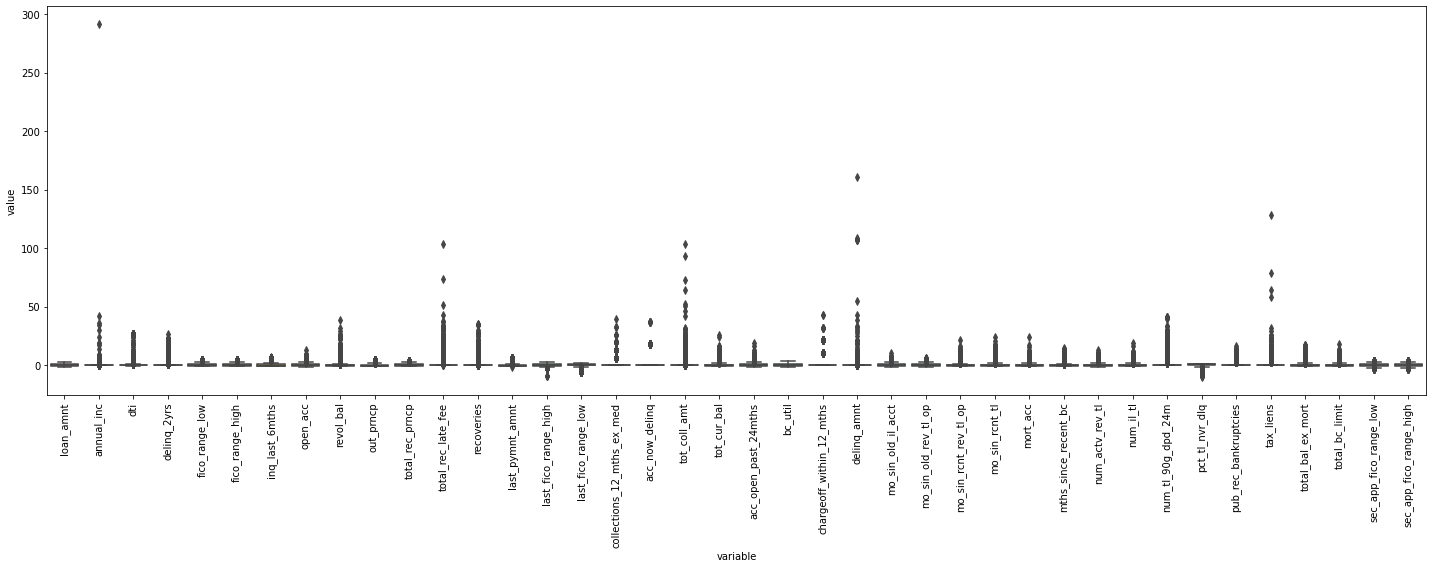

In [9]:
plt.figure(figsize=(20,8))
g = sns.boxplot(x="variable", y="value", data=pd.melt(scaled_data))
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

To get a sense for the overall outliers and to identify some of the more extreme cases, we standardized each of the continuous variables and examined the standardized boxplots (seen above). This highlights the extreme values in _annual income, delinquent amount, tax liens, total collection amounts ever owed, and late fees received to date_. It is also apparent that the dataset has outliers in most of the continuous variables. 

In [10]:
z_scores = z = np.abs(stats.zscore(data.select_dtypes(include=["number"]), nan_policy="omit"))

In [11]:
z_scores_df = pd.DataFrame(z_scores, columns=data.select_dtypes(include=["number"]).columns)

In [12]:
z_scores_df_mask = z_scores_df.gt(3)

In [13]:
z_value_dict = {}
for i in range(len(z_scores_df.columns)):
    feature_name = list(z_scores_df.columns)[i]
    x = z_scores_df_mask[feature_name].value_counts()
    if len(x)>1:
        z_value_dict[feature_name] = x[1]
    else: 
        z_value_dict[feature_name] = 0

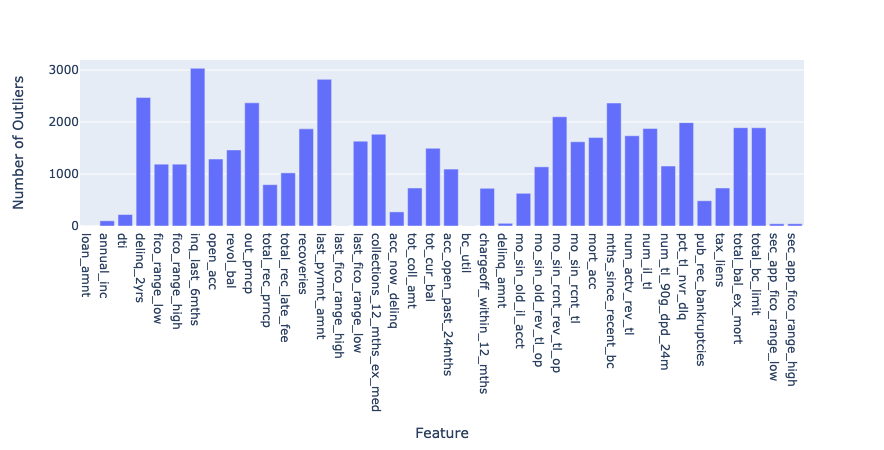

In [14]:
df_outliers = pd.DataFrame.from_dict(z_value_dict, orient="index").reset_index()
df_outliers = df_outliers.rename(columns={"index": "Feature", 0:"Number of Outliers"})
fig = px.bar(df_outliers, x='Feature', y='Number of Outliers')
fig.show()

We created this bar graph to determine how many outliers were contained within each attribute. Of course, exploring all outliers would be excessive, so we selected examples of attributes with extreme outliers to address in depth below.

In [15]:
# Explore Annual Income
data.nlargest(5, ['annual_inc'])

loan_amnt        term int_rate grade emp_length home_ownership  \
18753     10000.0   36 months   11.44%     B  10+ years       MORTGAGE   
92142     22000.0   36 months    5.32%     A  10+ years       MORTGAGE   
132830    10000.0   36 months    6.89%     A    3 years       MORTGAGE   
98600     38000.0   60 months    8.81%     A  10+ years       MORTGAGE   
66825      6000.0   36 months   16.14%     C    4 years       MORTGAGE   

        annual_inc verification_status    issue_d loan_status  \
18753   61000000.0     Source Verified 2017-03-01  Fully Paid   
92142    8900000.0     Source Verified 2017-04-01  Fully Paid   
132830   7600000.0     Source Verified 2015-09-01  Fully Paid   
98600    7200000.0            Verified 2019-04-01     Current   
66825    6286908.0     Source Verified 2019-02-01  Fully Paid   

                   purpose addr_state   dti  delinq_2yrs earliest_cr_line  \
18753   debt_consolidation         VA  0.01          0.0       1996-04-01   
92142          credit_card         FL  0.22          0.0       1994-11-01   
132830    home_improvement         SC  0.09         10.0       1989-02-01   
98600          credit_card         NY  0.24          0.0       2007-12-01   
66825   debt_consolidation         FL  0.08          0.0       2010-09-01   

        fico_range_low  fico_range_high  inq_last_6mths  open_acc  revol_bal  \
18753            690.0            694.0             1.0       3.0    14413.0   
92142            760.0            764.0             1.0       9.0    37284.0   
132830           700.0            704.0             1.0      18.0     2494.0   
98600            695.0            699.0             2.0      20.0    57205.0   
66825            660.0            664.0             1.0       5.0     7329.0   

       revol_util  out_prncp  total_rec_prncp  total_rec_late_fee  recoveries  \
18753       35.1%       0.00         10000.00                 0.0         0.0   
92142         39%       0.00         22000.00                 0.0         0.0   
132830      15.7%       0.00         10000.00                 0.0         0.0   
98600         51%   31119.72          6880.28                 0.0         0.0   
66825       63.7%       0.00          6000.00                 0.0         0.0   

       last_pymnt_d  last_pymnt_amnt  last_fico_range_high  \
18753    2020-03-01           330.17                 679.0   
92142    2020-04-01           662.34                 804.0   
132830   2016-01-01            26.53                 569.0   
98600    2020-05-01           785.32                 684.0   
66825    2019-09-01            63.32                 659.0   

        last_fico_range_low  collections_12_mths_ex_med application_type  \
18753                 675.0                         0.0       Individual   
92142                 800.0                         0.0       Individual   
132830                565.0                         0.0       Individual   
98600                 680.0                         0.0       Individual   
66825                 655.0                         0.0       Individual   

        acc_now_delinq  tot_coll_amt  tot_cur_bal  acc_open_past_24mths  \
18753              0.0           0.0      14413.0                   0.0   
92142              0.0           0.0     292988.0                   1.0   
132830             0.0         432.0      72572.0                   3.0   
98600              0.0           0.0     181773.0                   8.0   
66825              0.0           0.0      32877.0                   2.0   

        bc_util  chargeoff_within_12_mths  delinq_amnt  mo_sin_old_il_acct  \
18753      23.2                       0.0          0.0                 0.0   
92142      39.0                       0.0          0.0               144.0   
132830     19.1                       0.0          0.0               105.0   
98600      46.5                       0.0          0.0                84.0   
66825       3.1                       0.0          0.0               1

In [16]:
sum(data.annual_inc > 1000000)

35

_Annual Income_: While we expected income data to be right skewed with some high outliers, we took a closer look at the top few entries. Although the income level was very high, most of the records in this range were listed as verified.  This indicated borrowers submitted documents to LendingClub (such as pay stubs or bank statements), so we had no strong evidence that they were mistakes. However, we might consider restricting the range of annual income to less than 1 million dollars. We would only exclude 35 entries, and it is certainly possible that even though they are verified, these are data entry mistakes or falsifications on the part of the applicant. It is possible that someone with an annual income of 61 million dollars could take out a 10,000 dollar loan, but it would certainly be surprising.

In [17]:
# Explore Total Collection Amounts Ever Owed
data.nlargest(5, ['tot_coll_amt'])

loan_amnt        term int_rate grade emp_length home_ownership  \
17282    15000.0   36 months   10.42%     B    9 years           RENT   
41595     6600.0   36 months   15.41%     D    3 years       MORTGAGE   
93293    33600.0   60 months   11.80%     B  10+ years           RENT   
59060     5000.0   36 months    9.93%     B    5 years           RENT   
38644    10000.0   36 months   16.02%     C    3 years       MORTGAGE   

       annual_inc verification_status    issue_d loan_status  \
17282    125000.0     Source Verified 2017-12-01  Fully Paid   
41595     54000.0        Not Verified 2015-11-01  Fully Paid   
93293    120275.0        Not Verified 2019-01-01     Current   
59060     33000.0        Not Verified 2017-05-01  Fully Paid   
38644     63705.0        Not Verified 2017-05-01  Fully Paid   

                  purpose addr_state    dti  delinq_2yrs earliest_cr_line  \
17282  debt_consolidation         CO  10.46          0.0       1991-09-01   
41595         credit_card         CA   5.24          1.0       2004-10-01   
93293         credit_card         VA  18.21          0.0       1995-02-01   
59060  debt_consolidation         MO   4.07          0.0       2008-05-01   
38644  debt_consolidation         SC  29.35          0.0       2005-02-01   

       fico_range_low  fico_range_high  inq_last_6mths  open_acc  revol_bal  \
17282           680.0            684.0             1.0       9.0     7006.0   
41595           670.0            674.0             0.0      17.0     6287.0   
93293           710.0            714.0             0.0       7.0    19337.0   
59060           660.0            664.0             0.0       4.0     3329.0   
38644           660.0            664.0             1.0      12.0     4414.0   

      revol_util  out_prncp  total_rec_prncp  total_rec_late_fee  recoveries  \
17282      39.8%       0.00         15000.00                0.00         0.0   
41595      52.4%       0.00          6600.00                0.00         0.0   
93293      39.1%   26470.71          7129.29                0.00         0.0   
59060      32.3%       0.00          5000.00                0.00         0.0   
38644      39.1%       0.00         10000.00               17.58         0.0   

      last_pymnt_d  last_pymnt_amnt  last_fico_range_high  \
17282   2019-08-01          7738.29                 669.0   
41595   2016-09-01          5324.18                 534.0   
93293   2020-05-01           744.03                 719.0   
59060   2018-10-01          2987.04                 774.0   
38644   2019-07-01          3981.26                 664.0   

       last_fico_range_low  collections_12_mths_ex_med application_type  \
17282                665.0                         0.0       Individual   
41595                530.0                         0.0       Individual   
93293                715.0                         0.0       Individual   
59060                770.0                         0.0       Individual   
38644                660.0                         0.0       Individual   

       acc_now_delinq  tot_coll_amt  tot_cur_bal  acc_open_past_24mths  \
17282             0.0      188066.0     647047.0                   4.0   
41595             0.0      169257.0     429876.0                  10.0   
93293             0.0      132733.0      44327.0                   1.0   
59060             0.0      116695.0       3329.0                   0.0   
38644             0.0       94670.0     123125.0                   9.0   

       bc_util  chargeoff_within_12_mths  delinq_amnt  mo_sin_old_il_acct  \
17282      4.1                       0.0          0.0               315.0   
41595     70.7                       0.0          0.0               133.0   
93293     13.4                       0.0          0.0                90.0   
59060     40.0                       0.0          0.0                99.0   
38644     31.8                       0.0          0.0               125.0   

       mo_sin_old_rev_tl_op  mo_sin_rc

The most extreme value in _total collection amounts ever owed_ is high but not unreasonable. It does not appear to be an error, and only a few top values are over 100,000. This is important information, so excluding these values would be a poor option. 

In [18]:
# Explore Tax Liens
data.nlargest(5, ['tax_liens'])

loan_amnt        term int_rate grade emp_length home_ownership  \
121535     8500.0   36 months   16.02%     C  10+ years           RENT   
57889      7000.0   36 months   11.49%     B   < 1 year            OWN   
8952      12000.0   36 months   11.99%     C    4 years           RENT   
76768     18000.0   60 months   14.46%     C    6 years           RENT   
52939     20000.0   36 months   28.69%     F    3 years           RENT   

        annual_inc verification_status    issue_d  loan_status  \
121535    176000.0        Not Verified 2017-07-01  Charged Off   
57889      45000.0        Not Verified 2015-11-01   Fully Paid   
8952       60000.0     Source Verified 2015-12-01   Fully Paid   
76768      86000.0        Not Verified 2016-02-01   Fully Paid   
52939      68000.0     Source Verified 2017-02-01  Charged Off   

                   purpose addr_state    dti  delinq_2yrs earliest_cr_line  \
121535               other         IL   5.28          0.0       1992-12-01   
57889          credit_card         IN  34.37          0.0       1987-11-01   
8952    debt_consolidation         OR  14.12          0.0       1996-05-01   
76768   debt_consolidation         GA  15.11          0.0       1999-11-01   
52939                other         CA  10.10          0.0       1979-01-01   

        fico_range_low  fico_range_high  inq_last_6mths  open_acc  revol_bal  \
121535           690.0            694.0             3.0       9.0    15991.0   
57889            680.0            684.0             0.0      14.0    81045.0   
8952             680.0            684.0             0.0       9.0     4858.0   
76768            660.0            664.0             0.0      11.0     4014.0   
52939            685.0            689.0             0.0       5.0     7222.0   

       revol_util  out_prncp  total_rec_prncp  total_rec_late_fee  recoveries  \
121535      52.6%        0.0          3745.16                 0.0        0.00   
57889       18.7%        0.0          7000.00                 0.0        0.00   
8952        36.3%        0.0         12000.00                 0.0        0.00   
76768       41.8%        0.0         18000.00                 0.0        0.00   
52939       34.1%        0.0             0.00                 0.0    13459.54   

       last_pymnt_d  last_pymnt_amnt  last_fico_range_high  \
121535   2019-01-01           298.92                 539.0   
57889    2018-11-01           230.75                 799.0   
8952     2019-01-01             3.96                 549.0   
76768    2018-10-01          4012.42                 689.0   
52939           NaT             0.00                 584.0   

        last_fico_range_low  collections_12_mths_ex_med application_type  \
121535                535.0                         0.0       Individual   
57889                 795.0                         0.0       Individual   
8952                  545.0                         0.0       Individual   
76768                 685.0                         0.0       Individual   
52939                 580.0                         0.0       Individual   

        acc_now_delinq  tot_coll_amt  tot_cur_bal  acc_open_past_24mths  \
121535             0.0           0.0      24974.0                   6.0   
57889              0.0        1335.0      94584.0                   3.0   
8952               0.0        1988.0      23892.0                  10.0   
76768              0.0           0.0     144570.0                   3.0   
52939              0.0           0.0      31857.0                   4.0   

        bc_util  chargeoff_within_12_mths  delinq_amnt  mo_sin_old_il_acct  \
121535     70.4                       0.0          0.0               148.0   
57889      18.2                       0.0          0.0               140.0   
8952       68.9                       0.0          0.0                19.0   
76768      41.8                       0.0          0.0               147.0   
52939      38.6                       0.0          0.0    

The top few values in the _tax lien_ attribute are quite large. Tax leins occur when the government places a lien on a property because the individual has not properly paid taxes. The top value with 44 tax liens seems a poor candidate for a peer to peer loan, but it is not an implausible number. We cannot infer these outlying values are errors.

Overall, our dataset has outliers in most of the continuous variables. This is not unexpected in a large dataset with many financial attributes. Some, like _annual income_, might require a restricted range of values in order to eliminate values that seem unlikely to be correct. We have also identified _annual income, total credit revolving balance, total balance excluding mortgage, and total bankcard credit limit_ as attributes we may want to log transform if more normal distributions are necessary in future models.

Also it is important to note: which outliers actually affect the outcome of a given model (for example predicting loan grade) depends heavily on which model is applied and also what transforms are used to preprocess our data. Since we aren't considering all of the data and model pipelines we might use to classify in their fully fleshed out form, we can't know which ones have high Cook's D or leverage, for example. 

## New Features

Although we created new features later in our exploratory data analysis process, we would like to introduce them at this point. This will allow us to remove the secondary FICO attributes we temporarily kept before we address data types and simple statistics. More importantly, we would like to use some of our new features when we visualize our data in later sections. For instance, our simplified loan outcome variable (described below) allows for visualizations that are easier to interpret in some instances.

In [19]:
def str_to_rate(x: str):
    if isinstance(x, str):
        x = x[:-1]
        return float(x)
    elif np.isnan(x):
        return x
    else:
        pass
    
def remove_pattern(pattern: str, original: str):
    if isinstance(original, str):
        original = original.lower()
        return int(re.sub(pattern, '', original ))
    else:
        return np.nan
        
def str_date(x: str):
    if isinstance(x, str):
        x = datetime.datetime.strptime(x, '%b-%Y')
    else:
        x= np.nan
    return x

def credit_days(date2: datetime.date, date1: datetime.datetime.date):
    if isinstance(date2, datetime.date) and isinstance(date1, datetime.date):
        difference = date2 - date1
        return int(difference.days)
    else:
        return np.nan

def build_hist(data: pd.DataFrame, x: str):
    fig = px.histogram(data, x=x)
    fig.show()
    
def hist_by_group(data: pd.DataFrame,x: str, grp: str):
    fig = px.histogram(data, x=x,
        color = grp)
    fig.show()

In [20]:
#  Drop nan from earliest_cr_line  to ensure the credit_days function runs properly
#crates new feature called days_with_credit from issue_d and earliest_cr_line
data = data.dropna(subset=["earliest_cr_line"], axis=0)
data['days_with_credit'] = data[['issue_d','earliest_cr_line']].apply(lambda x: credit_days(*x), axis=1)

In [21]:
# Overall intial FICO score called 'overall_fico' that includes a secondary applicants score were applicable
# Most recent FICO score called 'last_fico' that uses initial FICO score if there was no "last" value
data['fico'] = (data['fico_range_high']+data['fico_range_low'])/2
data['last_fico'] = data['last_fico_range_high']-2
data['last_fico'] = np.where(data['last_fico']<=0,data['fico'],data['last_fico'])
data['sec_app_fico'] = (data['sec_app_fico_range_high']+data['sec_app_fico_range_low'])/2
data['overall_fico'] = data[['fico', 'sec_app_fico']].mean(axis=1)
fico_to_drop = ['fico','fico_range_high','fico_range_low',
                'last_fico_range_high','last_fico_range_low',
                'sec_app_fico_range_high','sec_app_fico_range_low','sec_app_fico']
data.drop(fico_to_drop,axis=1,inplace=True)

In [22]:
# Creating good_loan_or_not column - consolidating loan_status column
good_loan_status = ['Fully Paid','Current','In Grace Period','Issued']
bad_loan_status = ['Charged Off','Late (31-120 days)','Late (16-30 days)','Default']
#'Fully Paid' in good_loan_status
def loan_flag(loan_st: str):
    if loan_st in good_loan_status:
        x = 1
        return x
    else:
        x = 0
        return x
# create good_loan_or_not column 
data["good_loan_or_not"] = data["loan_status"].apply(lambda x: loan_flag(x))

First we created a variable called _Days with Credit._ This calculates the number of days between an individual's earliest credit line and the issue date of the loan. The two variables that we used to calculate _Days with Credit_ are not very useful to us in their original format, but we theorize that the length of a person's credit history could be useful in determining the outcome of their loan.

Next we created two new FICO score variables. There were six different FICO-related variables in the original data set, so we wanted to simplify them. First was _Overall FICO._ This averaged the high and low original FICO score of the applicant.  When there was a secondary applicant on a loan, it averaged the secondary high and low score, and took the average between the primary and secondary applicant.  Next was _Last FICO._ This averaged the most recent high and low FICO score (the difference between them was four, so we just subtracted 2) and imputed the original FICO value if there was no record of a more recent score.

Finally we created a _Good Loan or Not_ variable. The original data set had eight different loan statuses. Our main goal was to predict if a loan was a good investment.  We grouped "charged off", "late", and "default" individuals together in a bad status, and grouped "fully paid", "current", "in grace period", and "issued" into a good loan status. We can potentially use this new feature as a response variable if we desire a simple yes/no prediction from future models. It will also be useful for exploratory data analysis. Visualization with just two response categories will make it easier to identify potential contributing attributes to loan status.

Another variable we have discussed is _FICO difference_ where we took the difference between an individual's initial and most recent FICO scores. We hypothesize that an increase or reduction in score could indicate a higher or lower chance of successful repayment.

## Data Meaning Type

In [23]:
# convert int rate string to float
data["int_rate"] = data["int_rate"].apply(lambda x: str_to_rate(x) )

# convert revol_util string to float
data["revol_util"] = data["revol_util"].apply(lambda x: str_to_rate(x) )

#### Fix Data Types
We converted string values to float values for the attributes _interest rate_ and _revolving line utilization rate_ so they will be usable and the correct data type moving forward.

In [24]:
data_dic = pd.read_excel('Lab1.xlsx', usecols='A:D', nrows=57,index_col=0)

In [25]:
dataTypes = pd.DataFrame(data.dtypes).reset_index()
data_dic = pd.merge(data_dic, dataTypes, left_on="CSV Feature Name", right_on="index") 
data_dic = data_dic.rename(columns={"Type":"Attribute Type",0: "Data Type", "CSV Feature Name": "Feature"})
data_dic = data_dic[["Feature","Attribute Type","Data Type", "Description"]]
f = data_dic.groupby(['Attribute Type',"Feature","Data Type","Description"]).count()

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 36800 to 46436
Data columns (total 54 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   loan_amnt                   100000 non-null  float64       
 1   term                        100000 non-null  object        
 2   int_rate                    100000 non-null  float64       
 3   grade                       100000 non-null  object        
 4   emp_length                  100000 non-null  object        
 5   home_ownership              100000 non-null  object        
 6   annual_inc                  100000 non-null  float64       
 7   verification_status         100000 non-null  object        
 8   issue_d                     100000 non-null  datetime64[ns]
 9   loan_status                 100000 non-null  object        
 10  purpose                     100000 non-null  object        
 11  addr_state                  100000 n

In [27]:
display(HTML(f.to_html() ))

As you can see in the table above, we have 9 nominal, 3 ordinal, 3 interval, and 39 ratio variables.

## Simple Statistics

In [28]:
data[["loan_amnt","int_rate", "annual_inc", "overall_fico", "dti"]].select_dtypes(include=["number"]).describe()

loan_amnt       int_rate    annual_inc   overall_fico  \
count  100000.000000  100000.000000  1.000000e+05  100000.000000   
mean    15508.063500      12.899395  8.157653e+04     701.583268   
std      9663.942389       4.951915  2.090239e+05      33.604747   
min      1000.000000       5.310000  0.000000e+00     602.000000   
25%      8000.000000       8.990000  4.800000e+04     677.000000   
50%     13200.000000      12.290000  6.800000e+04     694.500000   
75%     21000.000000      15.990000  9.700000e+04     719.500000   
max     40000.000000      30.990000  6.100000e+07     847.500000   

                 dti  
count  100000.000000  
mean       20.739231  
std        36.981877  
min        -1.000000  
25%        12.200000  
50%        18.350000  
75%        25.290000  
max       999.000000

In [29]:
data[["term","emp_length","home_ownership","purpose","hardship_flag"]].select_dtypes(include=["object"]).describe()

term emp_length home_ownership             purpose hardship_flag
count       100000     100000         100000              100000        100000
unique           2         11              5                  12             2
top      36 months  10+ years       MORTGAGE  debt_consolidation             N
freq         69954      32324          48761               55439         95095

### Simple Statistics Summary 

The two tables above show simple statistics for a subset of numeric and object features. These are used to create generic profiles for loans and borrowers. These profiles are important in order to get a high-level understanding of the loans given and the borrowers. Knowing this basic information can help with future modeling decisions and/or interpretations. 


#### Loan Profile

The average loan amount is for \\$15,508 with an interest rate of 12.89%. 
The most common payback term used for these loans is 36 months. Interestingly, most of the loans are reportedly being used for debt consolidation.
According to the data, the maximum loan amount ever given is \$40,000 while the maximum interest rate reported is 30.90%, which is double the 75th percentile of all the interest rates reported (15.9%). 

#### Borrower Profile
The average borrower has been employed 10+ years, owns a home on which they are currently paying a mortgage, has an average annual income of \$81,576.53 and an average FICO score of 701. Furthermore, 75% of all the loans in the dataset come from borrowers with FICO scores below 719. Our dataset average FICO score is very close to the 711 average credit score in the US  <a href="https://www.businessinsider.com/personal-finance/average-credit-score">reported by Experian in 2020. </a>  
Dti stands for the borrower’s total debt obligations (excluding mortgage) and self-reported annual income. For this dataset, the average _dti_ is 19.63% and the 75th percentile is 25.27%.  

<b>Note:</b> On the table above it appears that _dti_ has a huge range (-1 to 999). In reality, this range is not representative of the actual values for these features. As seen below in the <b>closer look to dti</b> section, 99% of all the values are between 0 and 50.75. This means that in 99% of all the instances, the dti does <b>not</b> go higher than 50%.  The value 999 stands for loans with borrowers that have not reported any income, while -1 seems to be a one-off case.






#### Closer look to dti

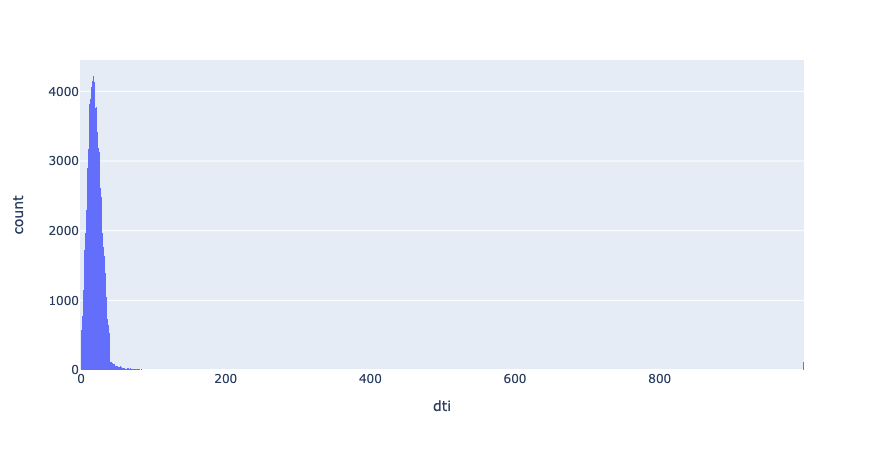

In [30]:
def build_hist(data: pd.DataFrame, x: str):
    fig = px.histogram(data, x=x)
    fig.show()
build_hist(data,"dti")

#### Dti Feature Quantiles

In [31]:
data["dti"].quantile(q=[0.25,0.05,0.75,0.90,0.95,0.99])

0.25    12.2000
0.05     5.0100
0.75    25.2900
0.90    31.7400
0.95    35.4800
0.99    53.1306
Name: dti, dtype: float64

### Interest rate and bad / good loans

In [32]:
inc_rate = data[["int_rate", "annual_inc", "loan_amnt", "good_loan_or_not"]]

In [33]:
bad_loans_with_hith_int_nom = inc_rate.query("good_loan_or_not==0 & int_rate>int_rate.mean()").shape[0]
bad_loans_with_hith_int_dem = inc_rate.query("good_loan_or_not==0").shape[0]

In [34]:
bad_loans_with_hith_int_dem

12417

In [35]:
good_loans_with_hith_int_nom = inc_rate.query("good_loan_or_not==1 & int_rate>int_rate.mean()").shape[0] 
good_loans_with_hith_int_dem = inc_rate.query("good_loan_or_not==1").shape[0]

In [36]:
from statsmodels.stats.proportion import proportions_ztest
p_value = proportions_ztest([bad_loans_with_hith_int_nom,good_loans_with_hith_int_nom],[good_loans_with_hith_int_nom,
                                                                                                            bad_loans_with_hith_int_dem])

In [37]:
print(f"""
    Percentage of bad loans with high interest rate: {100*(bad_loans_with_hith_int_nom/ bad_loans_with_hith_int_dem):,.2f}%
    Percentage of good loans with high interest rate: {100*(good_loans_with_hith_int_nom/ good_loans_with_hith_int_dem):,.2f}%
    
    The rate good loans with a interest rate higher than 12.89% (interest rate mean) is significantly lower than the
    one for bad loans (p-value: {p_value[1]:.5f})
      
      """)


    Percentage of bad loans with high interest rate: 65.84%
    Percentage of good loans with high interest rate: 41.00%
    
    The rate good loans with a interest rate higher than 12.89% (interest rate mean) is significantly lower than the
    one for bad loans (p-value: 0.00000)
      
      


## Visualize Attributes

annual_inc (annual income) can be an important factor to determine whether a loan will be good or bad. It is also in LendingClub's interest to understand the distribution of income of their customers. This boxplot of annual_inc is created by excluding outliers (very high income customers) and it provides a general visual of the annual income distribution of those that were approved for a loan at LendingClub. From the plot, we can see average income is around 81,000 and median is around 68,000. There were still people with zero income who were approved for a loan; the reason is worth exploring. Having excluded outliers, we can see the higher end of income of customers that are applying for loans is approximately 170,000.

<AxesSubplot:xlabel='annual_inc'>

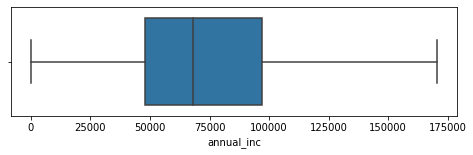

In [38]:
plt.figure(figsize=(8,2))
sns.boxplot(x = data['annual_inc'],showfliers = False)

_purpose_ of a loan can be useful information for LendingClub to know in terms of what their customers are using the loan for, and can be a helpful predictor in evaluating whether they will pay the loan back or not. A countplot/barplot is shown below, demonstrating the number of counts under each group in a straight forward manner. We can see the majority of customers are using loans for _debt_consolidation_, while the least amount of customers are using it for funding renewable energy. A decent percentage of customers are using the loan for their credit card or for home improvement. A small percentage of people are using it for major purchase, medical, house, small business, car, moving, vacation or other reasons.

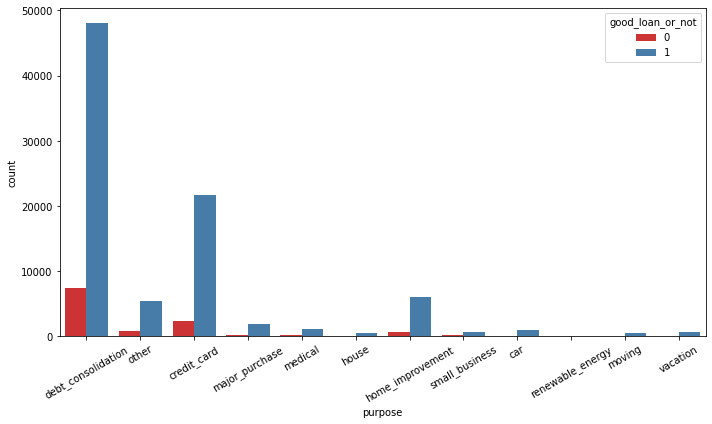

In [39]:
plt.figure(figsize=(10,6))
g = sns.countplot(x='purpose',hue='good_loan_or_not',data=data,palette='Set1')
g.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.tight_layout()
plt.show()

int_rate (interest rate) is LendingClub's indication of a customer's risk factor calculated at the time of application. Based on the link below, LendingClub's interest rate (histogram shown bottom middle) is derived from loan grade (countplot shown bottom right) information. We can see from the boxplot of interest rate (bottom left) the mean and median are around 12.5%. The minimum interest rate LendingClub offers is at 5.31%. A few customers have to pay over 24.30% (in the F and G grade group), some even as high as 30.99%. It is helpful to know the most common interest rates LendingClub offers, and it is very useful to know the relationship between _interest rate_ and _grade_. If we predict _grade_ in future models, _interest rate_ should be deleted since it is directly correlated.

_https://www.lendingclub.com/foliofn/rateDetail.action_

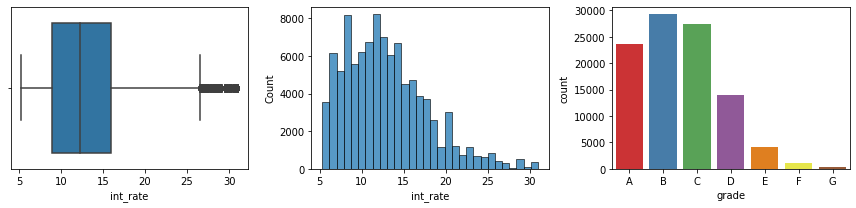

In [40]:
fig, ax = plt.subplots(1,3,figsize=(12,3))
sns.boxplot(x = data['int_rate'],ax=ax[0])
sns.histplot(x = data['int_rate'],bins=30, ax=ax[1])
sns.countplot(x='grade',data=data,palette='Set1', 
              order=['A','B','C','D','E','F','G'],ax=ax[2])
plt.tight_layout()

days_with_credit (days since customer has credit history) is a feature we created based on earliest_cr_line (earliest credit line). This is one of the most important factors that a lender considers when offering a loan. Two different types of plots for the same variable are created below. The histogram to the left depicts the distribution of _days with credit_ for LendingClub customers, with the most frequent value of around 4,000 days since earliest credit history, and the boxplot to the right shows us the distribution of days with credit visually. From the boxplot, we can tell the mean is around 6,000 days, and the median is a bit less around 5,400 days. The minimum is around 1,000 days while the maximum credit history goes back close to 25,000 days.

<AxesSubplot:xlabel='days_with_credit'>

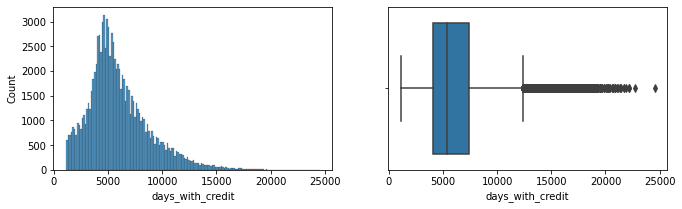

In [41]:
fig, ax = plt.subplots(1,2,figsize=(11,3))
sns.histplot(x = data['days_with_credit'],ax=ax[0])
sns.boxplot(x = data['days_with_credit'],ax=ax[1])

In [42]:
data['days_with_credit'].describe()

count    100000.000000
mean       5991.028900
std        2846.227732
min        1124.000000
25%        4110.000000
50%        5417.000000
75%        7427.000000
max       24531.000000
Name: days_with_credit, dtype: float64

last_fico (latest FICO score) and overall_fico (overall FICO score) are a consolidation of other FICO score columns provided. last_fico is the latest FICO score of the main applicant, while overall_fico is the average FICO score, which includes the secondary applicant's score if applicable. Obviously, FICO score is another major consideration of a borrower's lending risk, and the score itself includes many other factors. Interestingly, we can see from the boxplots below, when there is a secondary applicant involved, the principle applicant who already has a high FICO score gets averaged into a slightly lower range. The median for the principle applicant is over 700, while the overall median, which takes into consideration the secondary applicant when applicable, is below 700. By combining scores of both principle and secondary applicants, the interquartile range and min to max range both became tighter. For _overall FICO_ score, the average of two applicants is rarely above 780 (most are considered outliers on the plot). For both _last FICO_ score and _overall FICO_ score, the majority of applicants seem to be over 650; in other words, it is hard to get approved for a loan with credit score of 650 and below at LendingClub.

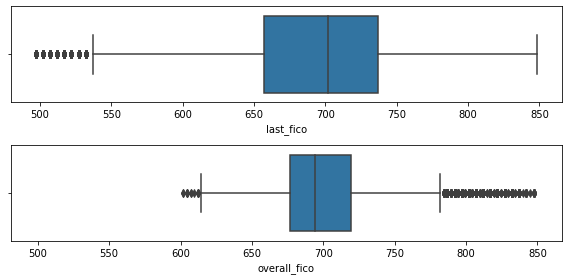

In [43]:
fig, ax = plt.subplots(2,1,figsize=(8,4))
sns.boxplot(x = data['last_fico'],ax=ax[0])
sns.boxplot(x = data['overall_fico'], ax=ax[1])
plt.xlim(481, 867)
plt.tight_layout()
plt.show()

## Explore Joint Attributes

In order to better understand our data, specifically as it pertains to the classification problems of whether a loan will be good or not or simply a loan's grade it is important to understand the relationships between the candidate variables we might use to model. 

In [44]:
# Joint plot data 
joint_data_df = data.copy(deep=False)      
joint_data_filtered_revol_bal_df = joint_data_df[(joint_data_df['revol_bal'] >= 1000) 
                                                 & (joint_data_df['revol_bal'] <= 100000)]

Text(0.5, 0.98, 'Last Fico Score vs Interest Rate of Loan')

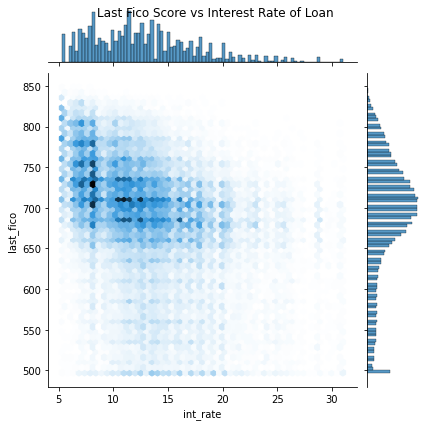

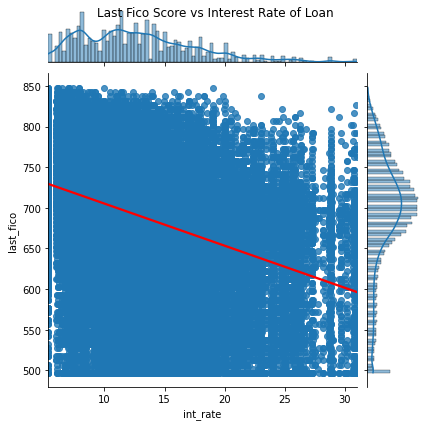

In [45]:
# Last Fico Score vs Interest Rate
sns.jointplot(x='int_rate',y='last_fico',data=joint_data_df,kind='hex')
plt.suptitle("Last Fico Score vs Interest Rate of Loan")

sns.jointplot(x='int_rate',y='last_fico',data=joint_data_df,kind='reg', joint_kws={'line_kws':{'color':'red'}})
plt.suptitle("Last Fico Score vs Interest Rate of Loan")

Although there are many interest rates and FICO scores in our dataset, as seen above, an individual with a lending club loan's last FICO Score appears to be negatively correlated to interest rate. This makes intuitive sense because an lender who would grant a loan, would need to make riskier loans more profitable to make up for the loss associated with the increased rate of defaulting. A FICO score is built to predict how likely an individual is to pay back a credit, so the relationship with Lending Club grade is logical. Both joint plots above gives us a direct visual of the relationship between the two variables we are interested. And the histograms on the side highlights the distribution of each variable. As can be seen, the confidence intervals for a predicted population mean are very narrow. This is because we are using a large dataset to perform our linear regression. 


https://www.investopedia.com/terms/f/ficoscore.asp 

Text(0.5, 0.98, 'Difference in FICO score vs Number of Inquires in the last 6 months')

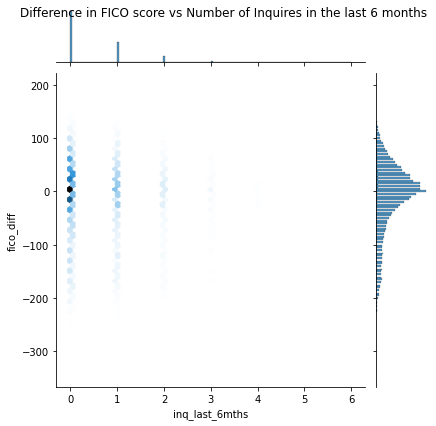

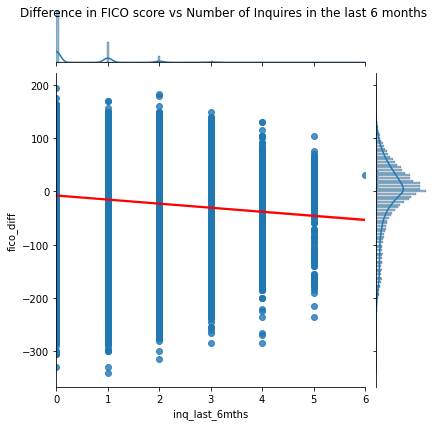

In [46]:
# Revolving credit utilization vs revolving credit balance
joint_data_df['fico_diff'] = joint_data_df.last_fico - joint_data_df.overall_fico
sns.jointplot(x='inq_last_6mths',y='fico_diff',data=joint_data_df,kind='hex')
plt.suptitle("Difference in FICO score vs Number of Inquires in the last 6 months")

sns.jointplot(x='inq_last_6mths',y='fico_diff',data=joint_data_df,kind='reg', joint_kws={'line_kws':{'color':'red'}})
plt.suptitle("Difference in FICO score vs Number of Inquires in the last 6 months")

When we look at the difference in FICO score from the initial application to the last FICO score collected, we can see that there is a change for many loan bearing individuals. Further, we can see that as an individual's FICO score drops over time, the number of inquiries for a loan actually grows. The reason for this negative correlation between change in FICO score and the number of loan inquires an individual makes is probably due to that individual needing a new loan to pay off other debt. In essence, inquiring about taking on a new loan to pay an old loan in an effort to avoid default. These two joint plots above visually demonstrate the two variables relationship. The histogram for each variable on the side also highlights the distribution of each variable. As can be seen, the confidence intervals for a predicted population mean are very narrow. This is because we are using a large dataset to perform our linear regression. 

Text(0.5, 0.98, 'Interest Rate vs Loan Amount - 2D Histogram')

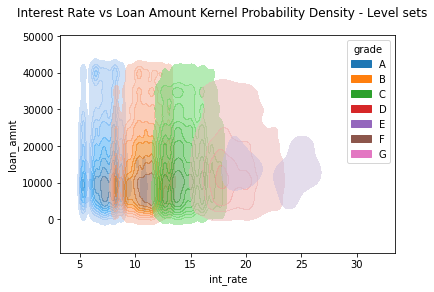

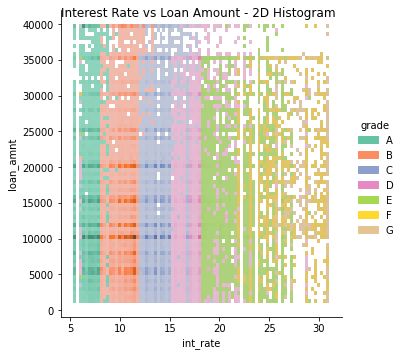

In [47]:
# Interest Rate vs Loan Amount By Grade Kernel Probability Density - Level sets 
sns.kdeplot(data=joint_data_df, x="int_rate", y="loan_amnt", hue="grade", hue_order=['A','B','C','D','E','F','G'], fill=True, alpha=.5)
plt.suptitle("Interest Rate vs Loan Amount Kernel Probability Density - Level sets")

sns.displot(joint_data_df, x="int_rate", y="loan_amnt", hue="grade", hue_order=['A','B','C','D','E','F','G'], kind="hist", palette="Set2")
plt.suptitle("Interest Rate vs Loan Amount - 2D Histogram")

When we look at Interest Rate vs Total Loan Amount, specifically by loan Grade, we can see that loan grade is very much correlated to Interest Rate on the kernel density plot colored by grade above. In fact, Interest Rate is largely determined by Loan Grades. What is interesting is that loan amount doesn't seem to affect interest rate, except for when the interest rate is very high. In that case, when a loan has a very low grade like a D or E, we can see that the maximum loan amount is generally capped at a lower number. This is likely because loaning institutions are mitigating risk with low graded loans. While the density plot gives us an visual of the shape for each loan amount distribution based on grade, the distribution plot below gives us a better visual on where the interest rate falls specifically under each group, such as, in group G most people gets 30+ percent on interest rate regardless of the loan amount they are applying for.

Text(0.5, 0.98, 'Interest Rate vs Loan Amount - 2D Histogram ')

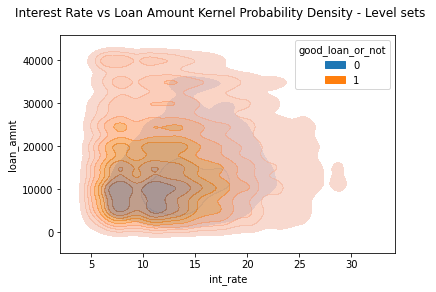

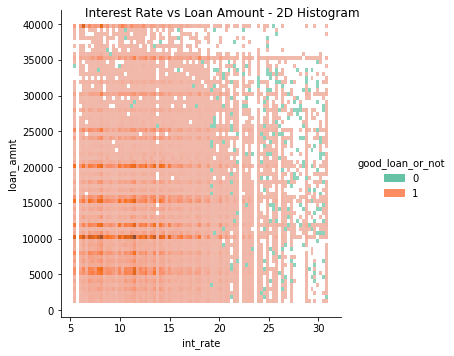

In [48]:
# Interest Rate vs Loan Amount By Good_Loan_Or_Not Kernel Probability Density - Level sets 
sns.kdeplot(data=joint_data_df, x="int_rate", y="loan_amnt", hue="good_loan_or_not", fill=True, alpha=.5)
plt.suptitle("Interest Rate vs Loan Amount Kernel Probability Density - Level sets ")

sns.displot(joint_data_df, x="int_rate", y="loan_amnt", hue="good_loan_or_not", kind="hist", palette="Set2")
plt.suptitle("Interest Rate vs Loan Amount - 2D Histogram ")

For comparisson, we ran the same analysis on Interest Rate vs Total Loan Amount but this time we analyized whether a loan was good or not. What is interesting is that you can see there is generally a lot of overlap. In other words, the relationship betweeen loan amount and interest rate does not seem to have any bearing on whether a loan is "good" or "bad". This is likely because loaners actually profit around the same amount off of "risky" loans due to their high interest rates. While the kernel density plot above shows us where majority lies under each level, the bottom distribution plot highlights individual cases and gives us a general sense of where individual falls under each level.

Text(0.5, 0.98, 'Pairs Regression Lines for Total Bank Card Utilization, Revolving Balance, Revolving Utilization, and Total Bank Card Limit')

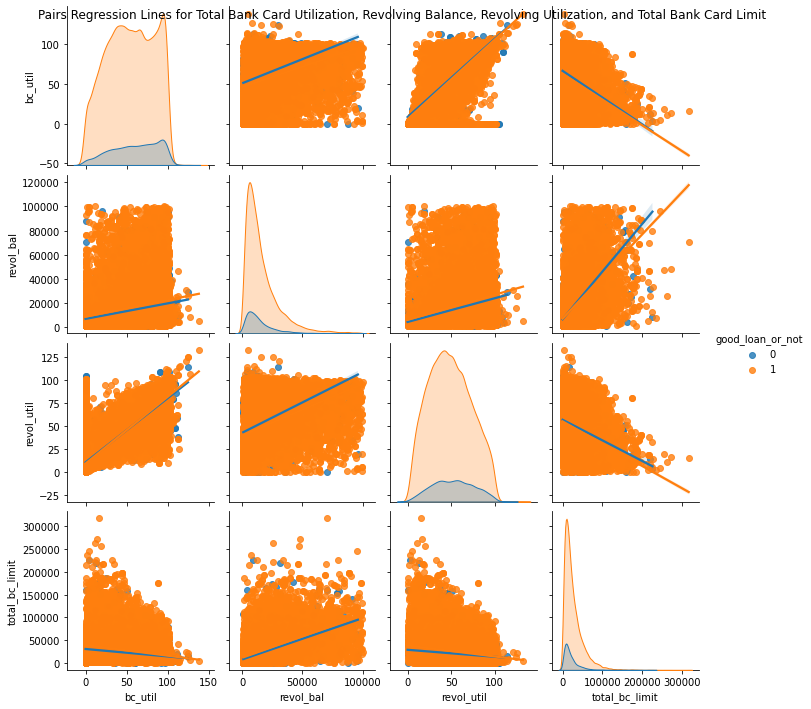

In [49]:
# Pairs Plots
joint_data_filtered_revol_bal_sub_sample_df = joint_data_filtered_revol_bal_df.sample(frac=0.5, replace=True, random_state=1)
sns.pairplot(joint_data_filtered_revol_bal_sub_sample_df[['bc_util', 'revol_bal', 'revol_util', 'total_bc_limit', 'good_loan_or_not']], hue="good_loan_or_not", kind="reg")
plt.suptitle("Pairs Regression Lines for Total Bank Card Utilization, Revolving Balance, Revolving Utilization, and Total Bank Card Limit")

After we filter out all revolving credit balances of 0 (no rolling debt for the loaner) we can see that there are direct relationships between Total Bank Card Utilization, Revolving Balance, Revolving Utilization percentage and Total Bank Card Limit. These properties are all moderately or heavily correlated with one another.  This makes sense if you think about it. Scatter plots with linear regression lines, with confidence intervals highlight the linear correlation between the variables in a visually interpretable way. The Kernel density plots, colorized by whether or not a loan was good are along the diagonal axis, which highlights potential separability of each variable. The following relationships exist between Total Bank Card Utilization, Revolving Balance, Revolving Utilization percentage and Total Bank Card Limit: 

#### Total Bank Card Utilization Vs. Revolving Balance: 
We can see that there is a moderately strong positive correlation between these two attributes. This makes sense because Revolving Balance represents the outstanding balance that rolls over for a loaner where as the Total Bank Card Utilization represents the percentage of a credit line that a given loaner has used. When the Bank Card Utilization (Credit line) is used more heavily, the amount that loaners are able to pay back in a given pay period (Month) likely goes down. 
    
#### Total Bank Card Utilization Vs. Revolving Utilization Percentage:   
There is a strong positive linear correlation between Revolving Utilization and Bank Card Utilization. This makes obvious sense as the two are by definition linked. As the revolving utilization of a credit line goes up for a loaner, so too does their overall percentage owed. Although these aren't perfectly correlated a loaner might have a high revolving utilization for a particular time frame, which still might be an overall small percentage of their total allowed credit, there is a strong correlation between these two attributes. The bottom line is these two properties can actually be thought of as fairly redundant. 
 
#### Total Bank Card Utilization Vs. Total Bank Card Limit: 
We can see that Total Bank Card Limit does appear to have a negative linear correlation with Total Bank Card Utilization. This could be due to a variety of reasons. For example, as the total credit limit goes up for a borrower, it is possible that they actually need the loan less because they are doing better financially. In other words, the lender is willing to allow them a higher credit limit because they are less of a risk. 
 
#### Revolving Balance Vs. Revolving Utilization Percentage:  
There is another strong positive correlation between Revolving balance and Revolving Utilization Percentage. This makes sense as the two represent very similar metrics (one is a percentage and one is a dollar amount). The only reason it isn't a pure 1:1 correlation, is that the revolving utilization includes the total balance in its calculation. These properties can be thought of as functionally redundant.  
 
#### Revolving Balance Vs. Total Bank Card Limit:  
Total Bank Card Limit does seem to have a moderately strong positive linear correlation to revolving balance. This is interesting because it means that the more rolling debt a loaner has,  on average, the more credit the lender is willing to let them have. This might be explained simply as a matter of scale. In other words a million dollar loan has higher payments, and in the case of a loaner not making full payments every payment period, that higher loan, with its higher payments, would carry a higher amount of rollover to the next payment period.  


#### Revolving Utilization Percentage Vs. Total Bank Card Limit:
Very similar to Total Bank Card Utilization Vs. Total Bank Card Limit, We can see that Revolving Utilization Percentage appears to have a negative linear correlation with Total Bank Card Utilization. This could be due to a variety of reasons. Again, Revolving Balance and Revolving Utilization Percentage are highly redundant so this makes sense. 

In [50]:
joint_data_numerical_df = joint_data_df.select_dtypes(include=[float,int])
joint_data_numerical_df = joint_data_numerical_df.drop(["good_loan_or_not"], axis=1)

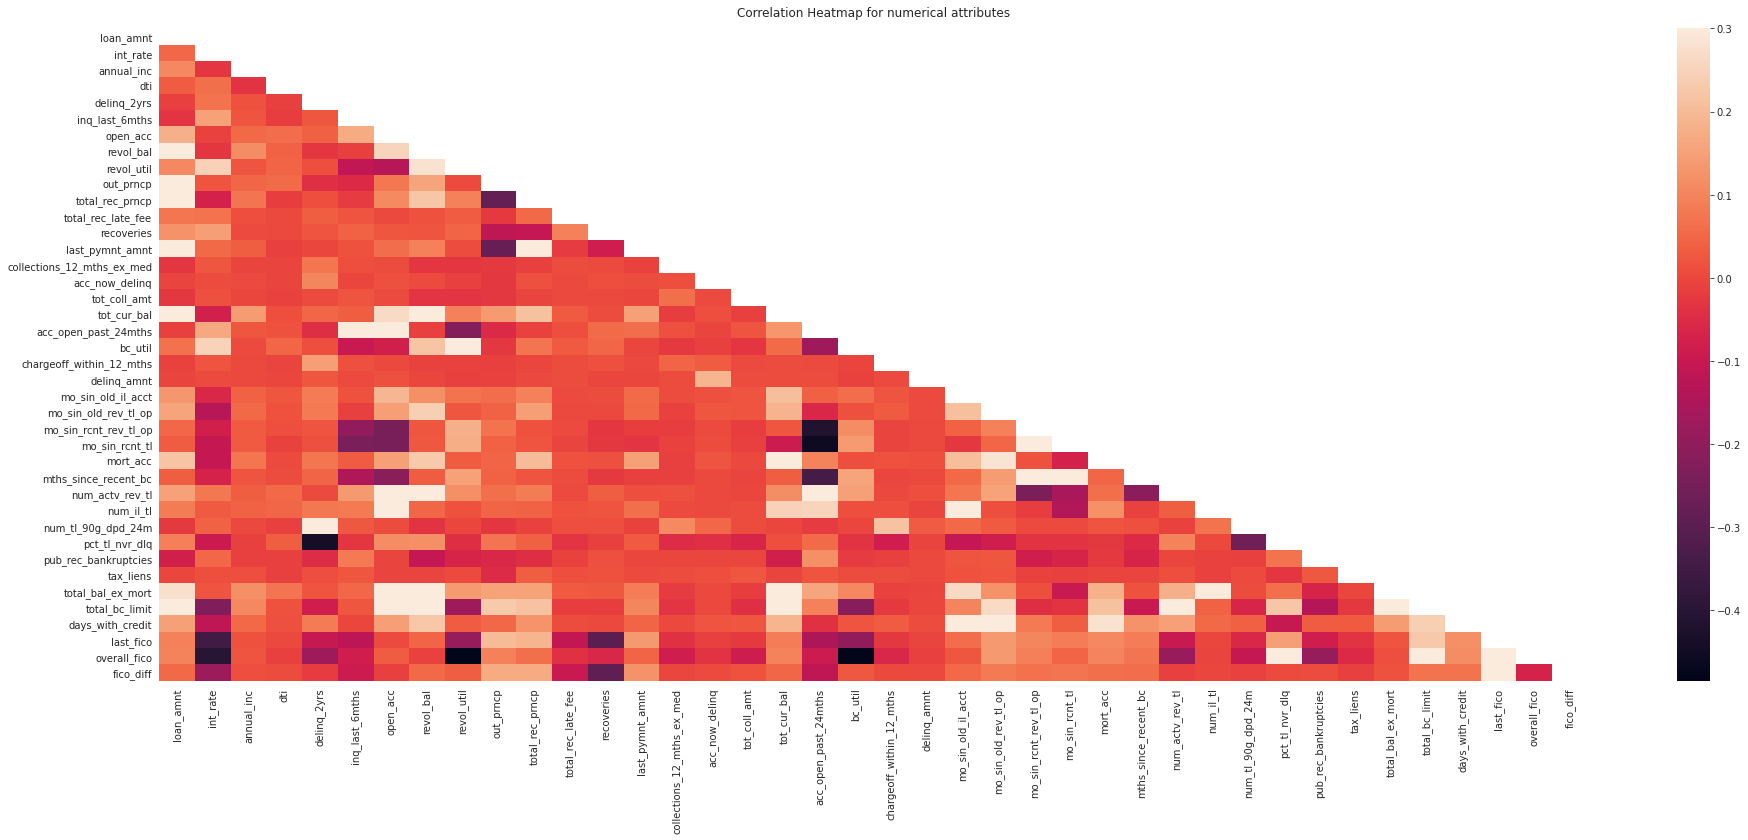

In [51]:
# correlation heat map for numerical data
# Increase the size of the heatmap.
corr = joint_data_numerical_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(32, 12))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=False).set_title('Correlation Heatmap for numerical attributes', fontdict={'fontsize':12}, pad=12)

When looking at all possible correlation or 'multicollinearity' between attributes in our data, we can see that many have low correlation or multicollinearity. We can see from a glance, that variables like Total Recovered Principal and Last Payment Amount are highly correlated, or for example Revolving Utilization and Bank Card Utilization are highly positively correlated. The important thing to note is that, whether or not we leave redundant or highly multicollinear variables in a particular model depends on our goal. If the goal is simply to provide strong classification prediction, then it makes sense to leave all the multicollinear variables in the model (provided we use some sort of feature selection which ensures positive variable importance for each of the remaining variables). However, if our goal is interpretation or some hypothesis test involving individual estimates for some generalized linear model (example logistic regression) we would absolutely want to remove all variables which have high multicollinearity and thus high variance inflation. 

A correlation heat map is a good way to quickly visualize many correlations between variables which may be interdependent. Although it may not get into the intricacies of why each variable is correlated, it at least helps us choose which variables would potentially have high variance inflation. 

Text(0.5, 0.98, 'Hierarchical Clustering with Euclidean distance for Numerical Attributes')

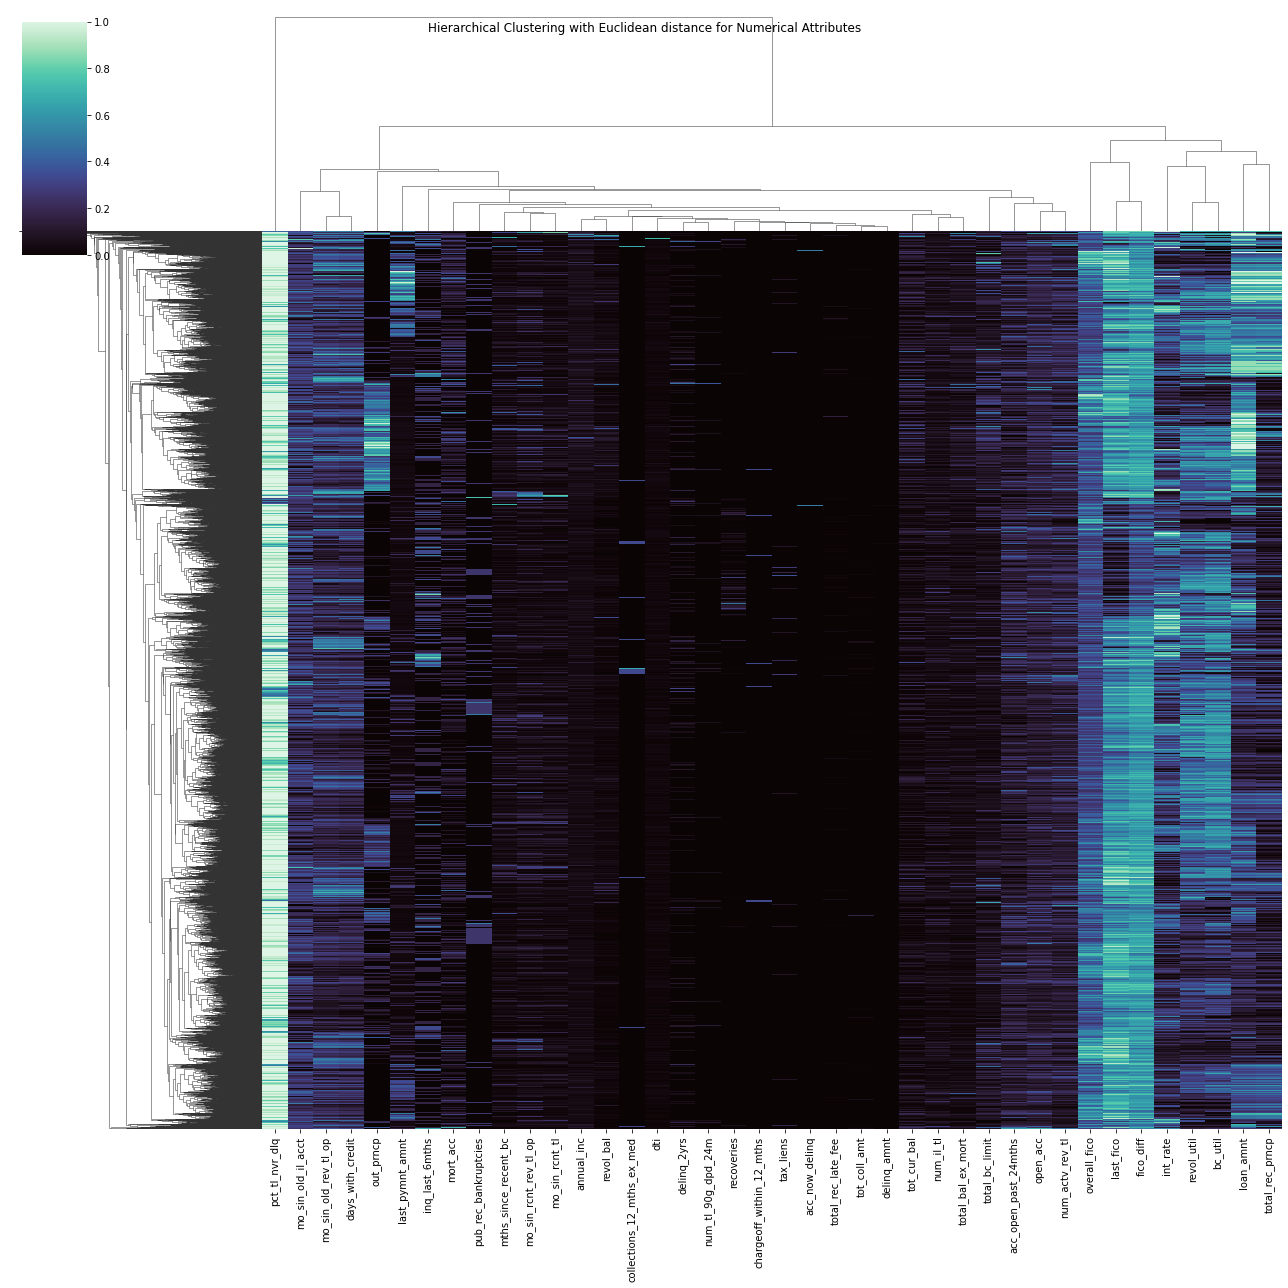

In [52]:
# Hierarchical Clustering with Euclidean distance as the similarity metric
joint_data_numerical_sub_sample_df = joint_data_numerical_df.sample(frac=0.15, replace=True, random_state=1)
cluster_map_euclidean = sns.clustermap(joint_data_numerical_sub_sample_df, metric="euclidean", standard_scale=1, cmap="mako", yticklabels=False, figsize=(18, 18))
cluster_map_euclidean.fig.suptitle('Hierarchical Clustering with Euclidean distance for Numerical Attributes') 

When we perform hierarchical cluster analysis with Euclidean distance on scaled numerical variables as our similarity metric, we can see some distinct clusters among our attributes. For example, on the right of the heat map above we can visually see that last_fico, overall_fico, interest rate, revolving utilization, and bc_util are all correlated in their own cluster. We can also see that Account Opened in the Past 24 months, open accounts, and number of actively revolving trades are clustered together and "similar" as well.

Hierarchical clustering with Euclidean distance is useful to quickly visualize related attributes. The dendrogram on the top shows linkages a.k.a. the various hierarchical clusters between each variable. 

Text(0.5, 0.98, 'Hierarchical Clustering with Euclidean distance for Numerical Attributes')

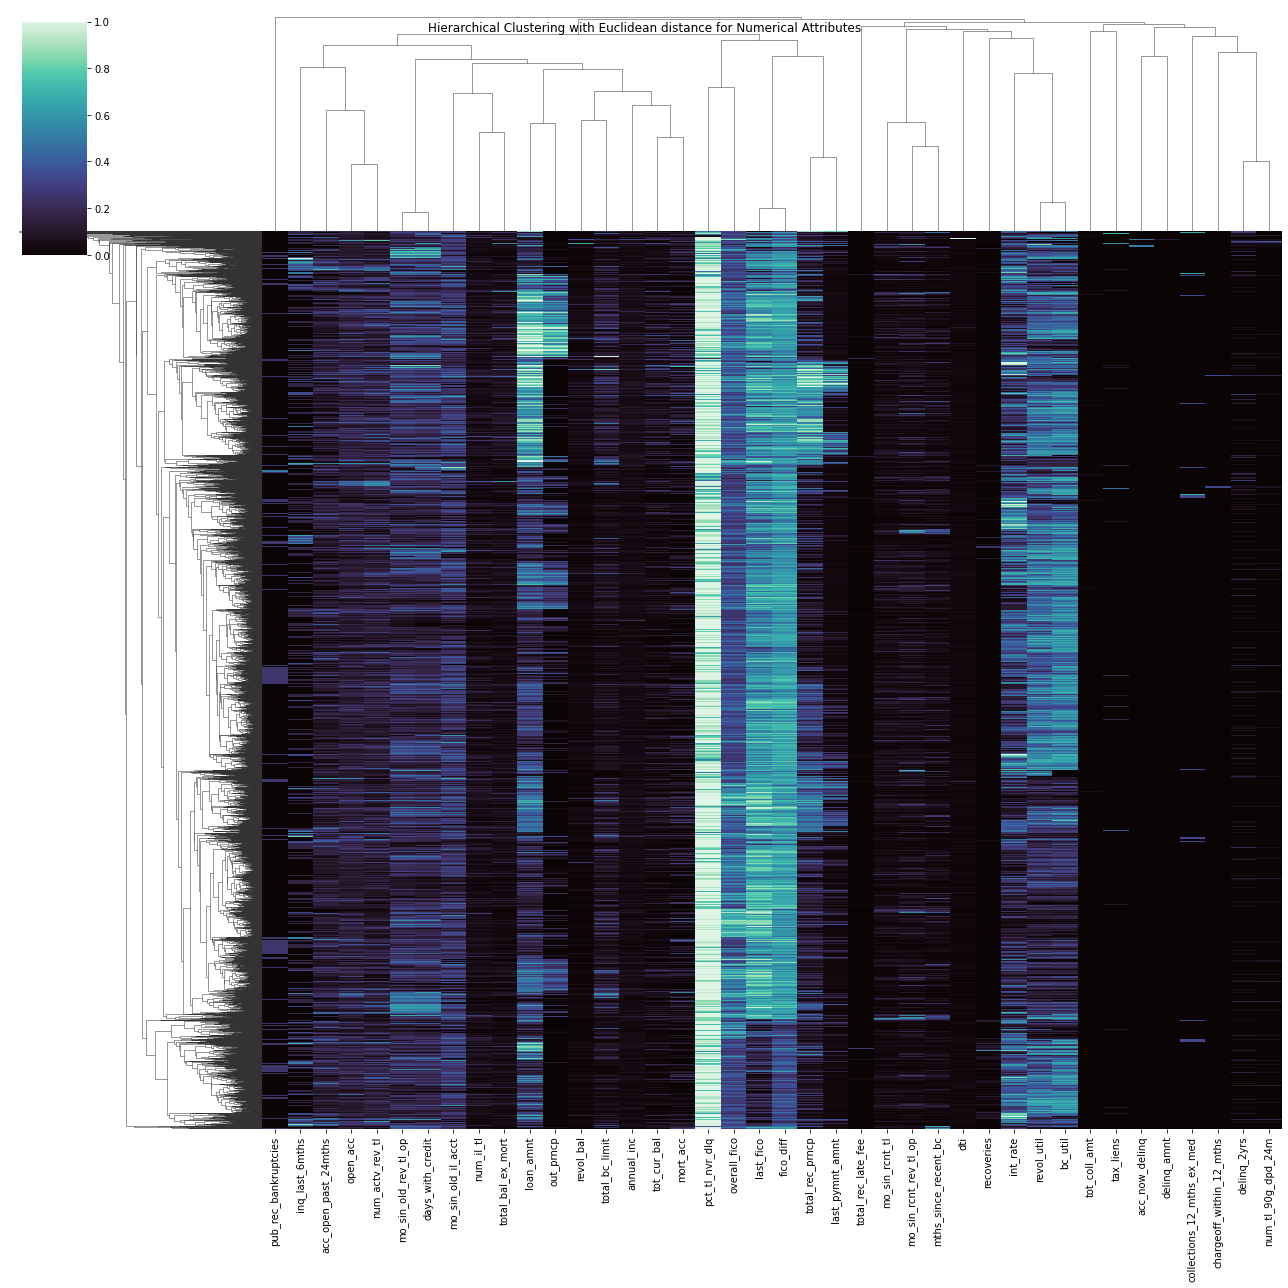

In [53]:
# Hierarchical Clustering Heat Map with correlation Matrix as the similarity metric (1-R) and Average Linkage algorithm 
# more here: https://online.stat.psu.edu/stat555/node/85/
# Note: Some of this code is ported from: https://stackoverflow.com/questions/27924813/extracting-clusters-from-seaborn-clustermap
# More information can be found on linkage methods and runtime complexity here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage

joint_data_numerical_sub_sample_df = joint_data_numerical_df.sample(frac=0.15, replace=True, random_state=1)
cluster_map_correlation = sns.clustermap(joint_data_numerical_sub_sample_df, metric="correlation", standard_scale=1, cmap="mako", yticklabels=False, figsize=(18, 18))
cluster_map_correlation.fig.suptitle('Hierarchical Clustering with Euclidean distance for Numerical Attributes') 

In order to check that our similarity metric didn't "over fit" in its cluster analysis due to euclidean distance, we use correlation as our similarity metric instead. We can readily see that some clustering relationships between attributes remain intact (when compared to the Euclidean method) but some change dramatically. For example, revolving_util and interest rate are both still considered very similar attributes, but last_fico and total bc_util are no longer in the same higher order cluster. The important take away is that if we use cluster analysis to analyze which attributes are similar and which are dissimilar, we should consider multiple distance metrics and possibly linkage algorithms and look at which clusters persist through most or all of the cluster analysis. Further, it should be noted that, without some complex distance metric such as Gower distance, we are only performing cluster analysis on numerical variables. If we included some sort of Gower distance it might become useful to perform multivariate cluster analysis. 

Note: To summarize: Agglomerative (bottom up) Hierarchical Clustering with correlation as a similarity metric designates to attributes as exactly similar (distance is 0) when their correlation coefficient is 1. This method is then extrapolated and partial correlation coefficients are generated for clusters of attributes and remaining unclustered or "unlinked" variables. More information on this method can be found here: https://online.stat.psu.edu/stat555/node/85/. 

## Explore Attributes and Class

grade
A    726.961943
B    702.411657
C    690.977013
D    685.080823
E    683.931170
F    682.574266
G    682.179558
Name: overall_fico, dtype: float64

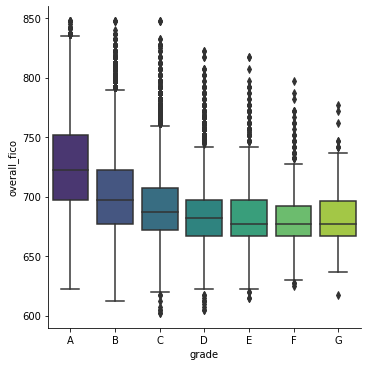

In [54]:
sns.catplot(x='grade',y='overall_fico',data=data,kind='box',order=['A','B','C','D','E','F','G'],palette='viridis')
grade_group = data.groupby(by='grade')
grade_group.overall_fico.mean()

It looks as though _overall FICO_ score plays a fairly strong role in the LendingClub grading process. This will probably be an important variable when we predict loan grade. Of course, FICO scores are based on a variety of financial measures, such as length of credit history, amount of credit owed, payment history, and the mix of credit available to an individual. Information related to all of these metrics is available within our dataset, so FICO score may render some of our attributes redundant. A FICO score is built to predict how likely an individual is to pay back a credit, so the relationship with Lending Club grade is logical. It is interesting to note that FICO score does not seem to be very helpful in predicting grades E through G. A boxplot is an appropriate visualization because we have one categorical and one continuous variable and we can easily see the relationship between the two. 

grade
A    3.863842
B    4.303518
C    4.801448
D    5.192277
E    5.601759
F    6.271157
G    6.472376
Name: acc_open_past_24mths, dtype: float64

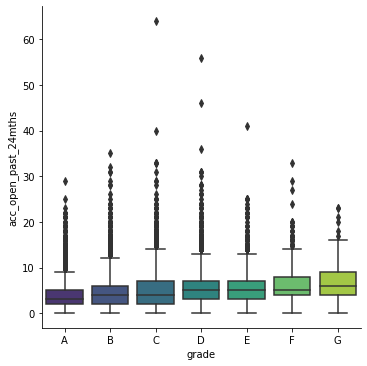

In [55]:
sns.catplot(x='grade',y='acc_open_past_24mths',data=data,kind='box',palette='viridis',order=['A','B','C','D','E','F','G'])
grade_group.acc_open_past_24mths.mean()

The attribute that reports the number of trades opened in the past 24 months also seems to play a role in the LendingClub grading process. Unlike FICO score, where grades E through G had nearly the same mean, this attribute steadily increases in mean. It would likely be a beneficial addition when predicting grade. The number of trades opened refers to all the different types of credit accounts an individual has open. These include credit, car payment, mortgage, other loans, and collections. More open accounts could mean an individual is overextended and may had difficulty paying back the LendingClub loan. A boxplot is an appropriate visualization because we have one categorical and one continuous variable and we can easily see the relationship between the two. 

grade
A    18.380769
B    19.708368
C    21.625600
D    24.033110
E    23.219249
F    23.857530
G    25.384088
Name: dti, dtype: float64

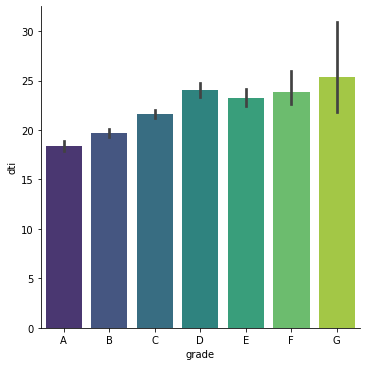

In [56]:
sns.catplot(x='grade',y='dti',data=data,kind='bar',order=['A','B','C','D','E','F','G'],palette='viridis')
grade_group.dti.mean()

Debt to income ratio (_dti_) is calculated using the individual's total monthly debt payments (not inlcuding mortgage or the LendingClub loan) divided by monthly income. _Dti_ appears to be associated with grade and could be especially useful in determining individuals who have been graded G. Debt to income is a good measure for the ability of an individual to pay off their debts. Of course, the higher the proportion of income an individual needs to use to pay off their debt, the less flexibility they may have to absorb unexpected expenses. This would increase the risk of providing them a loan. A barplot is an apporpriate visualization because we have one categorical and one continuous variable, and it allows us to see central tendency estimates as well as indications of uncertainty. _Dti_ has outliers that make a boxplot more difficult to interpret.

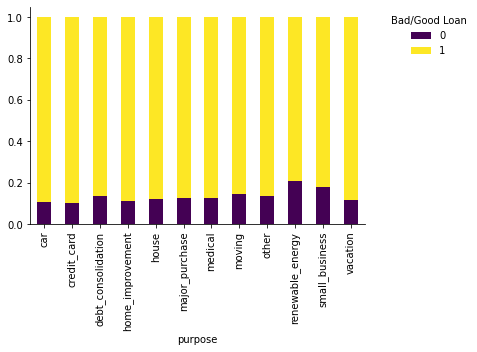

In [57]:
ct = pd.crosstab(data.purpose,data.good_loan_or_not,normalize='index')
ax=ct.plot.bar(stacked=True, rot=90, colormap='viridis') # rot changes bottom label orientation
plt.legend(title='Bad/Good Loan',bbox_to_anchor=(1.05, 1), frameon=False) # remove key frame, can change locations
ax.spines['top'].set_visible(False) # remove top border
ax.spines['right'].set_visible(False) # remove rt border
plt.show()

A look at the proportion of good and bad loans in each _purpose_ category indicates that higher percentages of loans for renewable energy and small businesses result in bad loan status. We chose to visualize the simplified response loan status variable for ease of interpretation. The renewable energy category has the fewest records, with only 53 individuals. The small sample size could account for the higher rate of bad loan statuses, but it is still worth noting. Small business loans had 910 records and the second highest rate of bad loans. Small businesses are diverse and may not be well established businesses yet. Our dataset includes information through the third quarter of 2020. COVID-19 and the resulting restrictions have been very tough on small businesses, which could be a contributing factor to the higher proportion of bad loans in the small business category. A bar graph with proportion of response by category is appropriate because these are two categorical variables, and there is an imbalance among the different purpose categories. It is easier to interpret proportions than it would be to interpret a bar graph with the counts in each category by response.

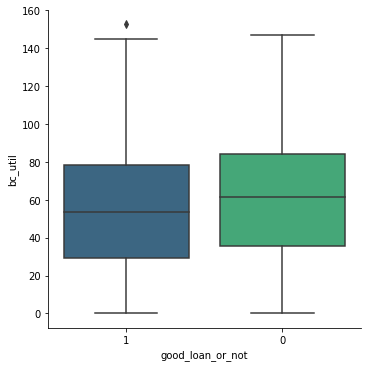

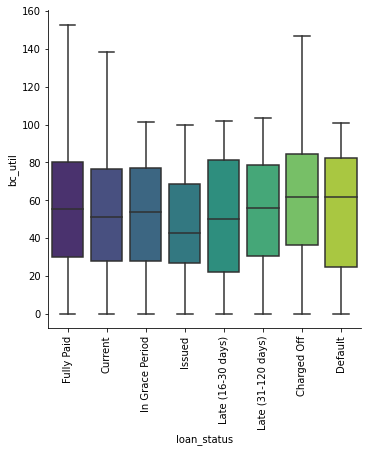

In [58]:
sns.catplot(x='good_loan_or_not',y='bc_util',data=data,kind='box',palette='viridis',order=[1,0]) # maybe put this sidebyside? or unnecessary
order=['Fully Paid','Current','In Grace Period','Issued','Late (16-30 days)','Late (31-120 days)','Charged Off','Default']
g = sns.catplot(x='loan_status',y='bc_util',data=data,kind='box',palette='viridis',order=order)
g.set_xticklabels(rotation=90)

The attribute bc_util measures the ratio of an individual's total current balance to their credit limit for all bankcard accounts. Higher mean bankcard utilization ratios seem to be associated with bad loan status. (We have grouped the four "bad" loan statuses on the right side of the graph.) We decided to visualize both the good/bad loan attribute as well as the more detailed loan status attribute for more granularity. While it looks like bankcard utilization rate could be promising, one potential problem is that the mean bankcard utilization for the "issued" loan status group is rather low. That could indicate borrowers started off with low utilization rates, and their utilization crept up over time. While this could be useful retrospectively or for reassessing loan investments, it might not be as useful for predictions regarding loan outcomes for new borrowers. A boxplot is an appropriate visualization because we have one categorical and one continuous variable and we can easily see the relationship between the two. 

In [59]:
data_copy = data.copy()

In [60]:
data_copy['fico_diff'] = data_copy.last_fico-data_copy.overall_fico

good_loan_or_not
0   -123.461766
1      4.348835
Name: fico_diff, dtype: float64

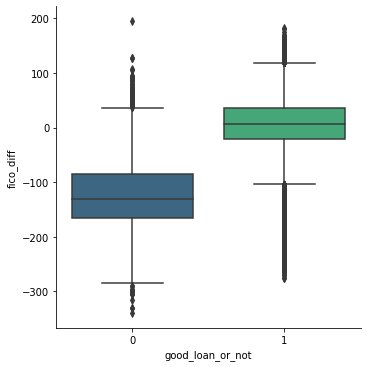

In [61]:
sns.catplot(x='good_loan_or_not',y='fico_diff',data=data_copy,kind='box',palette='viridis')
grade_group_copy = data_copy.groupby(by='good_loan_or_not')
grade_group_copy.fico_diff.mean()

During Feature Creation, we discussed creating a _FICO Difference_ attribute that measures the difference between an individual's initial overall FICO score and their most recent FICO score. We hypothesized that a negative change in FICO score should be associated with poor loan outcomes whereas a positive change should be associated with good loan outcomes. We were curious to see how this variable performed and if it would be useful in our model. We can see from the boxplot above that the good loan outcome group is associated with a higher _FICO Difference_ score. The good loan outcome group has a mean value in FICO difference of approximately four, whereas the bad loan outcome group has a mean value of -123. FICO scores are kept up to date and measure a combination of factors. It is intuitive that an individual with a large decline in their FICO score may be financially stressed and could be less likely to successfully pay back a loan. While this new attribute looks helpful in determining loan outcome, it comes with a major caveat. The change in FICO is being calculated after the loan has been approved. We cannot know the change in FICO score at the beginning of a loan. It might not be helpful in determining initial loan approvals, but it could be a useful tool to flag particular loans that might ultimately get charged off. A boxplot is an appropriate visualization because this is a continuous variable and a categorical variable and we wanted to examine the means and distributions of FICO difference by loan outcome.

## Exceptional Work

We spent a great deal of time during the data wrangling process attempting to understand our dataset and to pare it down to a manageable size. Forming an understanding of the original 141 attributes in order to eliminate some was time consuming. We researched the meaning behind many of the terms and used a correlation matrix to highlight the possibility of redundancy in some of the attributes. Then we individually examined the variables with high correlations to see how much they overlapped. We also used intuition and general knowledge to identify attributes that might not be as important to our target outcomes. While we willingly selected a larger dataset than was required, deciding what to keep and paring down the dataset took far longer than we anticipated.

Next, as highlighted in the "New Features" section, we created most of our new features rather than just identifying them. We took this a step further by incorporating some new features in the data visualization sections.

Below, we add a PCA analysis and build a random forest model for further exceptional work.

### Create X and Y

In [62]:
#Create X y variables
X, y = data.drop(["good_loan_or_not","loan_status","issue_d","earliest_cr_line",
           "last_pymnt_d"], axis=1), data.good_loan_or_not

### PCA

In [63]:
#PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X.select_dtypes(include=[float,int]))
scaled_data = scaler.transform(X.select_dtypes(include=[float,int]))
scaled_data = pd.DataFrame(scaled_data,columns =X.select_dtypes(include=[float,int]).columns )
pca = sk_PCA(n_components=8) # pick # of components
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

We performed a PCA on the continuous attributes in our dataset, and we decided to analyze the top eight principle components to visualize. Since we used Euclidean distance to analyze the importance of each variable, all continuous variables were first scaled prior to fitting. This gave all variables an equal opportunity to be evaluated on their importance on the first eight principle components.

The following heatmap plots the loading scores of each variable on every principle component. 0 on the y-axis denotes the first component and 7 on the y-axis denotes the 8th component. From the color scale, we can see some high loading scores (yellow and deep purple) starting from the second component. This gives us an overview of how important each variable is if we were to cut down on variables. But this does not give us a direct consideration regarding how useful they are in predicting the responses of interest.

<AxesSubplot:>

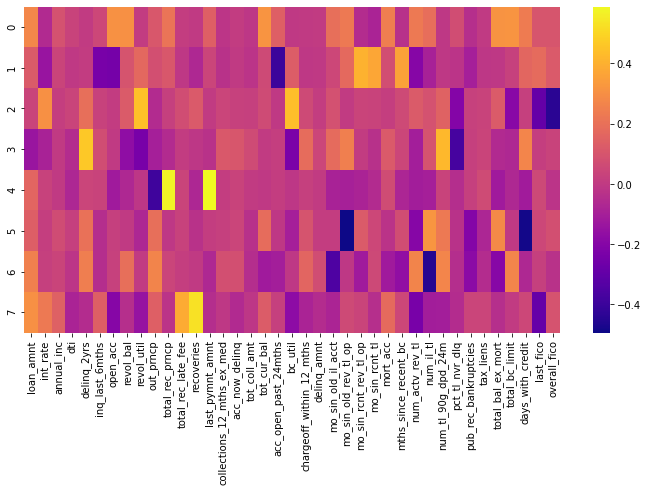

In [64]:
df_comp = pd.DataFrame(pca.components_)
df_comp.columns = scaled_data.columns
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma')

The following graph gives us a direct view of the separation of the response variable good_loan_or_not on the first two principle components among all numeric variables with yellow denoting a good loan and blue denoting a bad loan. We can see there is some separation based on the first two components but the separation is not great or deterministic.

Text(0, 0.5, 'Second Principal Component')

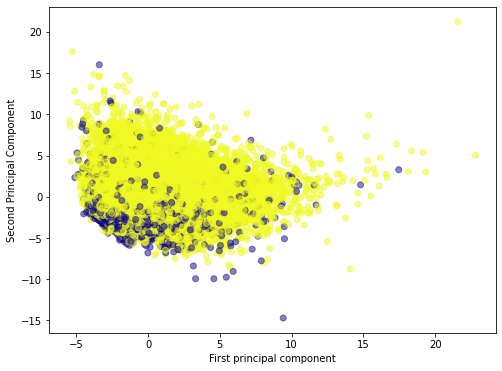

In [65]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=data["good_loan_or_not"],alpha=0.5,cmap='plasma')

plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

The following graph is a pairwise scatter plot between the first four principle components with good_loan_or_not denoted by different colors. Again, we can see there is separation between some components, such as PC2 and PC3, or PC1 and PC3. But the overall seperation is not deterministic between the two categories of the response. So we hypothesize continuous variables at least on the scaled version may not lead to the best prediction accuracy under each level.

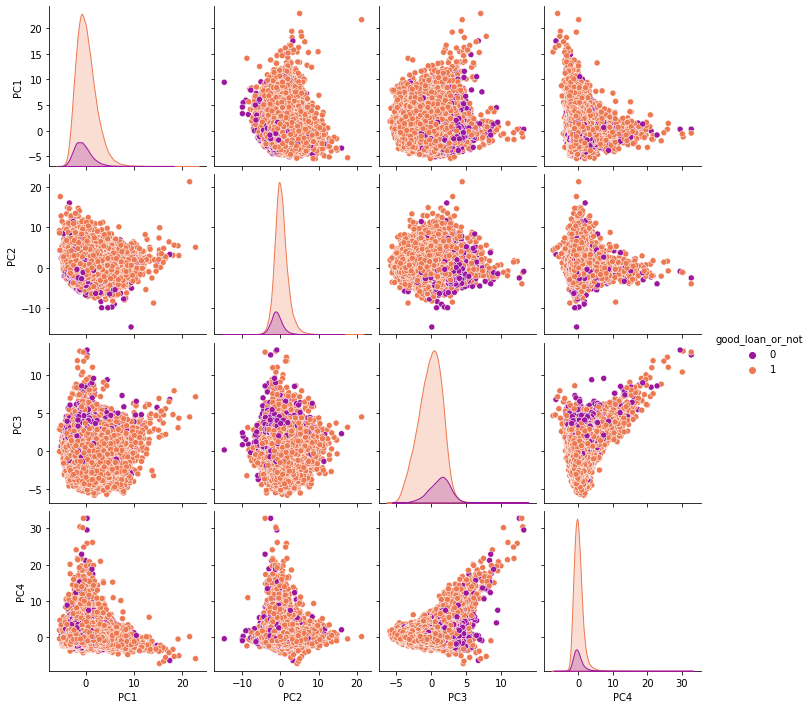

In [66]:
df_pca = pd.DataFrame(x_pca[:,:4], columns=["PC1","PC2","PC3","PC4"])
df_good_loan_or_not = pd.DataFrame(data["good_loan_or_not"],columns=["good_loan_or_not"])
df_good_loan_or_not = df_good_loan_or_not.reset_index()
df_pca = pd.concat([df_pca,df_good_loan_or_not],axis=1)
df_pca.drop("index",axis=1,inplace=True)
sns.pairplot(df_pca, hue="good_loan_or_not",palette='plasma')

The following cumulative variance plot gives us an idea of how much variance our first eight principle components explain among all 39 continuous variables we are analyzing. It looks as though with just eight principle components we are able to explain close to 50% of the variation. However, as denoted above, this does not indicate our continuous variables are very helpful in predicting our response of interest.

Cumulative Explained variance at 200 components: 0.48678445665969994


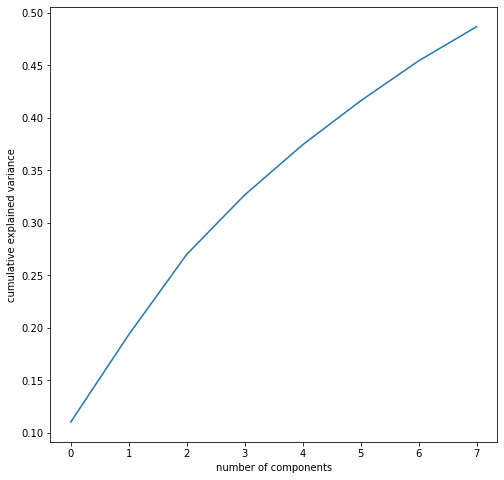

In [67]:
# Function obtained from:
# https://nbviewer.jupyter.org/github/jakemdrew/MachineLearningExtras/blob/master/LFW%20Dataset%20and%20Class%20Imbalance.ipynb
def plot_pca(pca):
    # Perform PCA on the data to reduce the number of initial features 
    # and to remove correlations that are common between pixel features 
    #pca = sk_PCA(n_components=X.shape[1])
    #pca.fit(X)

    # Inspect the explained variances to determine how many components to use  
    plt.subplots(figsize=(8, 8))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    print('Cumulative Explained variance at 200 components:',sum(pca.explained_variance_ratio_[0:199]) )  
plot_pca(pca)

### Random Forest


In [68]:
categorical_ix = X.select_dtypes(include=['object', 'bool']).columns

In [69]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [70]:
# define preprocessing for columns
t = [('cat', OneHotEncoder(), categorical_ix)]
#col_transform = ColumnTransformer(transformers=[t,'passthrough'])

col_transform = ColumnTransformer(t,remainder='passthrough')

fr = RandomForestClassifier()


In [71]:
pipeline = Pipeline(steps=[('preprocessing',col_transform), ('model', fr)])

In [72]:
# define CV
cv = KFold(n_splits=10, shuffle=True, random_state=1)

In [73]:
%%time
# evaluate the pipeline using cross validation
# Using X and Y instead of X_train y_train because we are doing CV to obtain the score
scores = cross_validate(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, 
                         return_estimator=True, return_train_score=True)

CPU times: user 1.18 s, sys: 2.63 s, total: 3.81 s
Wall time: 59.2 s


In [74]:
sorted(scores.keys())

['estimator', 'fit_time', 'score_time', 'test_score', 'train_score']

In [75]:
scores["train_score"]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [76]:
scores["test_score"]

array([0.99231843, 0.9913015 , 0.9913295 , 0.99036095,        nan,
       0.99426674, 0.99453302, 0.99334947, 0.98945066, 0.9892395 ])

In [77]:
%%time
# evaluate the pipeline using cross validation
# Using X and Y instead of X_train y_train because we are doing CV to obtain the score
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv,
                         n_jobs=-1)


CPU times: user 615 ms, sys: 180 ms, total: 795 ms
Wall time: 55.2 s


In [78]:
scores

array([0.9940814 , 0.99126369, 0.99084395, 0.98973638,        nan,
       0.99505415, 0.99411956, 0.9917581 , 0.99121939, 0.98923942])

## Random Forest Summary

#### Overall Model and Features
As part of exceptional work, we built a random forest model using almost all categorical and numeric features from our dataset. The only excluded features were: 
- <b>loan_status:</b> This feature was used to create the response variable (good_loan_or_not) so adding it will definitely overfit the model
- <b>issue_d</b>, <b>earliest_cr_line:</b> These two features were used to create the days_with_credit feature. 

- <b>last_pymnt_d:</b> This feature is in a datetime format, so we did not believe that without further transformation it would bring any value to the model

Random Forest was our model of choice due to the flexibility it provides in preprocessing the data. According to many online discussions (<a href="https://stackoverflow.com/questions/8961586/do-i-need-to-normalize-or-scale-data-for-randomforest-r-package">stackoverflow</a>, <a href="https://www.kaggle.com/questions-and-answers/86923">Kaggle</a>,  <a href="https://medium.com/rants-on-machine-learning/the-unreasonable-effectiveness-of-random-forests-f33c3ce28883">Medium</a>), Random Forest models do not need to scale or normalize the data, and this simplifies the prepossessing pipeline.

#### Model preprocessing pipeline

To fit the model we used SkLearn's <b>Pipeline</b>, <b>OneHotEncoder</b>, <b>ColumnTransformer</b> functions. 
The pipeline's only preprocessing step was to one hot encode all the categorical variables, once this was done these were fed into the RandomForest estimator along with the numerical variables.  


#### Model Evaluation
For model evaluation we used two cross validation functions <b>cross_validate</b> and <b>cross_val_score</b> and a scoring function optimizing for <b style="color:blue">roc_auc</b> within a 10 k-fold.

<b>cross_validate</b>
- Train scores: 100%
- Test scores: +99%

<b>cross_val_score</b>
- CV score: +99%

#### Model Evaluation
The model performance is extremely high. We believe that the reason for this is that one or some of the features being consumed by the model might be closely related to the response variable causing the model to easily memorize/derive the response.
We do not believe that the model is being overfitted. The reason for this is that the cross_validate function <b>test scores</b> are at par with the train score, meaning the model is actually outputting good predictions in unseen data. 

In future labs we plan on investigating this further and finding a root cause/interpretation for this high model performance. 


